PBL01_需要予測・在庫最適化　サンプルコード(PBL01_sample_code)   
似ているkaggleのnotebook lag関数やgroupbyを踏まえて, データの整形やり直し

# インポート

In [1]:
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

import math
import time
import datetime

# 複数のリストの直積（デカルト積）を生成するためのライブラリ
from itertools import product


#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer


from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# データの読み込み

In [2]:
sales = pd.read_csv('./inputs/sales_history.csv')
train = sales.copy()

cats = pd.read_csv('./inputs/item_categories.csv')
cat_names = pd.read_csv('./inputs/category_names.csv')

test = pd.read_csv('./inputs/test.csv')
sub = pd.read_csv('./inputs/sample_submission.csv', header=None)

## 外部データ

In [3]:
syukujitsu_df = pd.read_csv('./inputs/syukujitsu.csv', encoding="shift-jis")
syukujitsu_df.columns = ["日付", "holiday"]
syukujitsu_df["日付"] = pd.to_datetime(syukujitsu_df["日付"])

# データのマージ

「sales_history.csv」、「item_category.csv」、「category_names.csv」の3つのテーブルを統合する。

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119570 entries, 0 to 1119569
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   日付      1119570 non-null  object 
 1   店舗ID    1119570 non-null  int64  
 2   商品ID    1119570 non-null  int64  
 3   商品価格    1119570 non-null  int64  
 4   売上個数    1119570 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 42.7+ MB


In [5]:
train_merged_data_pre = pd.merge(train, cats, on='商品ID', how='left')
train_merged_data_pre = pd.merge(train_merged_data_pre, cat_names, on='商品カテゴリID', how='left')

train_merged_data_pre.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD


In [6]:
train_merged_data_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119570 entries, 0 to 1119569
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   日付        1119570 non-null  object 
 1   店舗ID      1119570 non-null  int64  
 2   商品ID      1119570 non-null  int64  
 3   商品価格      1119570 non-null  int64  
 4   売上個数      1119570 non-null  float64
 5   商品カテゴリID  1119570 non-null  int64  
 6   商品カテゴリ名   1119570 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 68.3+ MB


# 型変換

In [7]:
train_merged_data_pre[['店舗ID', '商品ID', '商品カテゴリID']] = train_merged_data_pre[['店舗ID', '商品ID', '商品カテゴリID']].astype(str)

train_merged_data_pre['日付'] = pd.to_datetime(train_merged_data_pre['日付'])

cats[['商品ID', '商品カテゴリID']] = cats[['商品ID', '商品カテゴリID']] .astype(str)
cat_names[['商品カテゴリID']] = cat_names[['商品カテゴリID']] .astype(str)

In [8]:
test[['index', '店舗ID', '商品ID']] = test[['index', '店舗ID', '商品ID']].astype(str)

# 月ブロック情報の追加

In [9]:
train_merged_data_pre[['year_cat', 'month_cat', 'day_cat']] = list(map(lambda text:text.split('-'), train_merged_data_pre["日付"].astype(str)))
train_merged_data_pre[['year', 'month', 'day']] = train_merged_data_pre[['year_cat', 'month_cat', 'day_cat']] .astype(int)

# 「年」と「月」の全組み合わせを作成する
gp_time = train_merged_data_pre.groupby(['year_cat', 'month_cat']).count().reset_index()[['year_cat', 'month_cat']]

## 月ブロック

In [10]:
# カラム名「月ブロック」として、通し番号をつける
gp_time['月ブロック'] = list(range(len(gp_time)))


gp_time = gp_time.append({
    '月ブロック': 22,
    'year_cat': '2019',
    'month_cat': '11',
}, ignore_index=True)

# testデータ用に、評価対象期間である2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    'year_cat': '2019',
    'month_cat': '12',
}, ignore_index=True)

# gp_time

In [11]:
# 「月ブロック」カラムをsalesに統合する
train_merged_data_pre = pd.merge(train_merged_data_pre, gp_time, on=['year_cat', 'month_cat'], how='left')
train_merged_data_pre

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD,2018,01,01,2018,1,1,0
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD,2018,01,01,2018,1,1,0
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD,2018,01,01,2018,1,1,0
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD,2018,01,01,2018,1,1,0
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD,2018,01,01,2018,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119565,2019-10-31,8,3400006,2700,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10,31,2019,10,31,21
1119566,2019-10-31,7,3400009,1020,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10,31,2019,10,31,21
1119567,2019-10-31,7,3400012,510,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10,31,2019,10,31,21
1119568,2019-10-31,4,3500001,340,1.0,350,本 - オーディオブック_タイプB,2019,10,31,2019,10,31,21


# 2018年12月のデータを用意

In [12]:
train_merged_data_pre_201812 = train_merged_data_pre[(train_merged_data_pre['日付'] >= '2018-12-01') & (train_merged_data_pre['日付'] <= '2018-12-30')]

# 前処理

# 誤って登録されたゴミデータの確認/修正

## 商品価格0以下

In [13]:
## 0以下の値
train_merged_data_pre[train_merged_data_pre.商品価格 <= 0]

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック
260519,2018-05-15,14,1300015,0,1.0,130,ゲーム - ゲーム機C,2018,05,15,2018,5,15,4
288866,2018-06-01,5,2100019,0,1.0,210,ギフト - ぬいぐるみ,2018,06,01,2018,6,1,5
288867,2018-06-01,6,2100019,0,1.0,210,ギフト - ぬいぐるみ,2018,06,01,2018,6,1,5
288868,2018-06-01,4,2100019,0,1.0,210,ギフト - ぬいぐるみ,2018,06,01,2018,6,1,5
288869,2018-06-01,13,2100020,0,1.0,210,ギフト - ぬいぐるみ,2018,06,01,2018,6,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998398,2019-07-27,5,1500208,0,1.0,150,ゲーム - ゲーム機B,2019,07,27,2019,7,27,18
998399,2019-07-27,3,1500208,0,1.0,150,ゲーム - ゲーム機B,2019,07,27,2019,7,27,18
998401,2019-07-27,7,1500208,0,1.0,150,ゲーム - ゲーム機B,2019,07,27,2019,7,27,18
998412,2019-07-27,2,1500229,0,1.0,150,ゲーム - ゲーム機B,2019,07,27,2019,7,27,18


In [14]:
train_merged_data_pre[train_merged_data_pre.商品価格 <= 0].商品ID.unique()

array(['1300015', '2100019', '2100020', '2100021', '2100026', '2100027',
       '2100028', '2100032', '2100034', '2100036', '2100037', '2100040',
       '2100041', '2100043', '2100044', '2100045', '2100052', '2100022',
       '2300120', '1100375', '1300273', '1300284', '1300293', '1300317',
       '1500208', '1500229', '1300304', '1500204', '1100302', '1300028'],
      dtype=object)

In [15]:
for index,data in train_merged_data_pre[train_merged_data_pre.商品価格<=0][['月ブロック', '店舗ID', '商品ID', '商品価格', '売上個数']][-20:].iterrows():
    print('index', index)
    display(train_merged_data_pre[(train_merged_data_pre.月ブロック==data[0])&(train_merged_data_pre.店舗ID==data[1])&(train_merged_data_pre.商品ID==data[2])][['月ブロック', '店舗ID', '商品ID','商品カテゴリ名', '商品価格', '売上個数']])
    print('*'*100)

index 997721


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
962517,18,16,1100375,PCゲーム - 通常版,0,1.0
964871,18,16,1100375,PCゲーム - 通常版,0,1.0
966223,18,16,1100375,PCゲーム - 通常版,0,1.0
967677,18,16,1100375,PCゲーム - 通常版,0,1.0
969373,18,16,1100375,PCゲーム - 通常版,0,1.0
970717,18,16,1100375,PCゲーム - 通常版,0,2.0
971942,18,16,1100375,PCゲーム - 通常版,0,1.0
975722,18,16,1100375,PCゲーム - 通常版,0,1.0
981569,18,16,1100375,PCゲーム - 通常版,0,1.0
985206,18,16,1100375,PCゲーム - 通常版,0,1.0


****************************************************************************************************
index 997722


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
962510,18,5,1100375,PCゲーム - 通常版,0,5.0
962519,18,5,1100375,PCゲーム - 通常版,0,1.0
963660,18,5,1100375,PCゲーム - 通常版,0,1.0
970719,18,5,1100375,PCゲーム - 通常版,0,1.0
970720,18,5,1100375,PCゲーム - 通常版,0,1.0
973123,18,5,1100375,PCゲーム - 通常版,340,6.0
973128,18,5,1100375,PCゲーム - 通常版,0,1.0
975726,18,5,1100375,PCゲーム - 通常版,0,1.0
977299,18,5,1100375,PCゲーム - 通常版,2040,1.0
981565,18,5,1100375,PCゲーム - 通常版,0,1.0


****************************************************************************************************
index 997723


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
962516,18,11,1100375,PCゲーム - 通常版,2040,1.0
962521,18,11,1100375,PCゲーム - 通常版,0,1.0
963664,18,11,1100375,PCゲーム - 通常版,2040,1.0
970722,18,11,1100375,PCゲーム - 通常版,0,1.0
989697,18,11,1100375,PCゲーム - 通常版,0,1.0
992051,18,11,1100375,PCゲーム - 通常版,0,1.0
993388,18,11,1100375,PCゲーム - 通常版,0,2.0
996181,18,11,1100375,PCゲーム - 通常版,0,2.0
996188,18,11,1100375,PCゲーム - 通常版,0,1.0
997723,18,11,1100375,PCゲーム - 通常版,0,2.0


****************************************************************************************************
index 997724


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
963668,18,0,1100375,PCゲーム - 通常版,0,1.0
966226,18,0,1100375,PCゲーム - 通常版,2040,1.0
967678,18,0,1100375,PCゲーム - 通常版,0,3.0
969370,18,0,1100375,PCゲーム - 通常版,0,1.0
970716,18,0,1100375,PCゲーム - 通常版,0,3.0
980394,18,0,1100375,PCゲーム - 通常版,0,1.0
981567,18,0,1100375,PCゲーム - 通常版,0,1.0
985205,18,0,1100375,PCゲーム - 通常版,0,1.0
986618,18,0,1100375,PCゲーム - 通常版,2040,2.0
988297,18,0,1100375,PCゲーム - 通常版,0,1.0


****************************************************************************************************
index 998165


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
980744,18,12,1300273,ゲーム - ゲーム機C,0,1.0
991281,18,12,1300273,ゲーム - ゲーム機C,2550,1.0
998165,18,12,1300273,ゲーム - ゲーム機C,0,1.0


****************************************************************************************************
index 998166


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
969809,18,0,1300273,ゲーム - ゲーム機C,0,1.0
988739,18,0,1300273,ゲーム - ゲーム機C,0,2.0
998166,18,0,1300273,ゲーム - ゲーム機C,0,1.0
1002729,18,0,1300273,ゲーム - ゲーム機C,2550,1.0


****************************************************************************************************
index 998168


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
966672,18,8,1300273,ゲーム - ゲーム機C,2550,1.0
969812,18,8,1300273,ゲーム - ゲーム機C,0,1.0
985553,18,8,1300273,ゲーム - ゲーム機C,2550,1.0
992441,18,8,1300273,ゲーム - ゲーム機C,0,1.0
998168,18,8,1300273,ゲーム - ゲーム機C,0,1.0


****************************************************************************************************
index 998169


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
962904,18,10,1300273,ゲーム - ゲーム機C,0,1.0
972308,18,10,1300273,ゲーム - ゲーム機C,2550,1.0
974744,18,10,1300273,ゲーム - ゲーム機C,0,1.0
976199,18,10,1300273,ゲーム - ゲーム機C,0,2.0
990050,18,10,1300273,ゲーム - ゲーム機C,0,1.0
995148,18,10,1300273,ゲーム - ゲーム機C,0,1.0
998169,18,10,1300273,ゲーム - ゲーム機C,0,1.0
999483,18,10,1300273,ゲーム - ゲーム機C,2550,1.0


****************************************************************************************************
index 998181


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
965308,18,10,1300293,ゲーム - ゲーム機C,3400,1.0
968207,18,10,1300293,ゲーム - ゲーム機C,0,1.0
969831,18,10,1300293,ゲーム - ゲーム機C,0,1.0
971111,18,10,1300293,ゲーム - ゲーム機C,0,1.0
973558,18,10,1300293,ゲーム - ゲーム機C,0,3.0
977910,18,10,1300293,ゲーム - ゲーム機C,0,2.0
979492,18,10,1300293,ゲーム - ゲーム機C,0,1.0
979496,18,10,1300293,ゲーム - ゲーム機C,3400,1.0
983084,18,10,1300293,ゲーム - ゲーム機C,0,1.0
983086,18,10,1300293,ゲーム - ゲーム機C,0,1.0


****************************************************************************************************
index 998182


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
964099,18,5,1300293,ゲーム - ゲーム機C,0,1.0
971114,18,5,1300293,ゲーム - ゲーム機C,0,2.0
990067,18,5,1300293,ゲーム - ゲーム機C,0,1.0
991290,18,5,1300293,ゲーム - ゲーム機C,0,1.0
993772,18,5,1300293,ゲーム - ゲーム機C,0,1.0
998182,18,5,1300293,ゲーム - ゲーム機C,0,1.0


****************************************************************************************************
index 998183


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
965308,18,10,1300293,ゲーム - ゲーム機C,3400,1.0
968207,18,10,1300293,ゲーム - ゲーム機C,0,1.0
969831,18,10,1300293,ゲーム - ゲーム機C,0,1.0
971111,18,10,1300293,ゲーム - ゲーム機C,0,1.0
973558,18,10,1300293,ゲーム - ゲーム機C,0,3.0
977910,18,10,1300293,ゲーム - ゲーム機C,0,2.0
979492,18,10,1300293,ゲーム - ゲーム機C,0,1.0
979496,18,10,1300293,ゲーム - ゲーム機C,3400,1.0
983084,18,10,1300293,ゲーム - ゲーム機C,0,1.0
983086,18,10,1300293,ゲーム - ゲーム機C,0,1.0


****************************************************************************************************
index 998184


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
962918,18,7,1300293,ゲーム - ゲーム機C,4250,1.0
964097,18,7,1300293,ゲーム - ゲーム機C,0,1.0
965312,18,7,1300293,ゲーム - ゲーム機C,0,1.0
971115,18,7,1300293,ゲーム - ゲーム機C,0,1.0
972324,18,7,1300293,ゲーム - ゲーム機C,0,1.0
980759,18,7,1300293,ゲーム - ゲーム機C,0,1.0
981914,18,7,1300293,ゲーム - ゲーム機C,0,1.0
984308,18,7,1300293,ゲーム - ゲーム機C,0,1.0
988763,18,7,1300293,ゲーム - ゲーム機C,0,2.0
993771,18,7,1300293,ゲーム - ゲーム機C,0,1.0


****************************************************************************************************
index 998199


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
966700,18,3,1300317,ゲーム - ゲーム機C,0,1.0
968225,18,3,1300317,ゲーム - ゲーム機C,0,1.0
969844,18,3,1300317,ゲーム - ゲーム機C,0,1.0
969846,18,3,1300317,ゲーム - ゲーム機C,0,1.0
972341,18,3,1300317,ゲーム - ゲーム機C,0,1.0
987196,18,3,1300317,ゲーム - ゲーム機C,0,1.0
990076,18,3,1300317,ゲーム - ゲーム機C,3400,1.0
993788,18,3,1300317,ゲーム - ゲーム機C,0,1.0
998199,18,3,1300317,ゲーム - ゲーム機C,0,1.0
998202,18,3,1300317,ゲーム - ゲーム機C,0,1.0


****************************************************************************************************
index 998201


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
969842,18,11,1300317,ゲーム - ゲーム機C,0,1.0
971135,18,11,1300317,ゲーム - ゲーム機C,0,1.0
979510,18,11,1300317,ゲーム - ゲーム機C,0,1.0
984318,18,11,1300317,ゲーム - ゲーム機C,0,1.0
984319,18,11,1300317,ゲーム - ゲーム機C,0,1.0
998201,18,11,1300317,ゲーム - ゲーム機C,0,1.0
999511,18,11,1300317,ゲーム - ゲーム機C,3400,1.0


****************************************************************************************************
index 998202


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
966700,18,3,1300317,ゲーム - ゲーム機C,0,1.0
968225,18,3,1300317,ゲーム - ゲーム機C,0,1.0
969844,18,3,1300317,ゲーム - ゲーム機C,0,1.0
969846,18,3,1300317,ゲーム - ゲーム機C,0,1.0
972341,18,3,1300317,ゲーム - ゲーム機C,0,1.0
987196,18,3,1300317,ゲーム - ゲーム機C,0,1.0
990076,18,3,1300317,ゲーム - ゲーム機C,3400,1.0
993788,18,3,1300317,ゲーム - ゲーム機C,0,1.0
998199,18,3,1300317,ゲーム - ゲーム機C,0,1.0
998202,18,3,1300317,ゲーム - ゲーム機C,0,1.0


****************************************************************************************************
index 998398


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
963044,18,5,1500208,ゲーム - ゲーム機B,0,1.0
978197,18,5,1500208,ゲーム - ゲーム機B,0,1.0
998398,18,5,1500208,ゲーム - ゲーム機B,0,1.0


****************************************************************************************************
index 998399


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
965520,18,3,1500208,ゲーム - ゲーム機B,0,1.0
966857,18,3,1500208,ゲーム - ゲーム機B,0,1.0
970039,18,3,1500208,ゲーム - ゲーム機B,0,1.0
970041,18,3,1500208,ゲーム - ゲーム機B,0,1.0
971281,18,3,1500208,ゲーム - ゲーム機B,0,-1.0
971287,18,3,1500208,ゲーム - ゲーム機B,0,1.0
978198,18,3,1500208,ゲーム - ゲーム機B,3400,1.0
988976,18,3,1500208,ゲーム - ゲーム機B,3400,1.0
998399,18,3,1500208,ゲーム - ゲーム機B,0,1.0


****************************************************************************************************
index 998401


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
965523,18,7,1500208,ゲーム - ゲーム機B,0,1.0
966855,18,7,1500208,ゲーム - ゲーム機B,0,1.0
976424,18,7,1500208,ゲーム - ゲーム機B,0,1.0
980919,18,7,1500208,ゲーム - ゲーム機B,0,1.0
987437,18,7,1500208,ゲーム - ゲーム機B,3400,1.0
988974,18,7,1500208,ゲーム - ゲーム機B,0,1.0
990232,18,7,1500208,ゲーム - ゲーム機B,0,1.0
992629,18,7,1500208,ゲーム - ゲーム機B,0,1.0
995372,18,7,1500208,ゲーム - ゲーム機B,0,1.0
998401,18,7,1500208,ゲーム - ゲーム機B,0,1.0


****************************************************************************************************
index 998412


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
964240,18,2,1500229,ゲーム - ゲーム機B,0,1.0
973721,18,2,1500229,ゲーム - ゲーム機B,0,1.0
979706,18,2,1500229,ゲーム - ゲーム機B,0,1.0
984477,18,2,1500229,ゲーム - ゲーム機B,0,1.0
985735,18,2,1500229,ゲーム - ゲーム機B,0,1.0
995383,18,2,1500229,ゲーム - ゲーム機B,0,1.0
998412,18,2,1500229,ゲーム - ゲーム機B,0,1.0


****************************************************************************************************
index 998413


,月ブロック,店舗ID,商品ID,商品カテゴリ名,商品価格,売上個数
965532,18,5,1500229,ゲーム - ゲーム機B,0,1.0
987446,18,5,1500229,ゲーム - ゲーム機B,0,1.0
998413,18,5,1500229,ゲーム - ゲーム機B,0,1.0


****************************************************************************************************


ゲーム機が多い, 何かとセットで買われた場合は, 価格0としてカウントされる？

In [16]:
train_merged_data_pre[(train_merged_data_pre['日付'] == '2019-07-03') & (train_merged_data_pre['店舗ID'] == '15') & \
                     train_merged_data_pre['商品カテゴリ名'].str.contains('ゲーム')]

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック
964842,2019-07-03,15,1100302,1190,1.0,110,PCゲーム - 通常版,2019,07,03,2019,7,3,18
964873,2019-07-03,15,1100375,1600,1.0,110,PCゲーム - 通常版,2019,07,03,2019,7,3,18
964874,2019-07-03,15,1100375,0,1.0,110,PCゲーム - 通常版,2019,07,03,2019,7,3,18
964913,2019-07-03,15,1100408,760,1.0,110,PCゲーム - 通常版,2019,07,03,2019,7,3,18
964986,2019-07-03,15,1100433,870,1.0,110,PCゲーム - 通常版,2019,07,03,2019,7,3,18
965275,2019-07-03,15,1300239,2720,1.0,130,ゲーム - ゲーム機C,2019,07,03,2019,7,3,18
965288,2019-07-03,15,1300272,4250,2.0,130,ゲーム - ゲーム機C,2019,07,03,2019,7,3,18
965296,2019-07-03,15,1300273,0,1.0,130,ゲーム - ゲーム機C,2019,07,03,2019,7,3,18
965317,2019-07-03,15,1300304,0,1.0,130,ゲーム - ゲーム機C,2019,07,03,2019,7,3,18
965319,2019-07-03,15,1300306,3400,1.0,130,ゲーム - ゲーム機C,2019,07,03,2019,7,3,18


In [17]:
train_merged_data_pre[train_merged_data_pre.商品ID=='2100019'].商品価格.values

array([1240, 1240, 1240, 1240,  870,  870,  870,  870,  870,  870,  870,
        870,  570,  870,  870,  870,  870,  870,  870,  390,  560,  560,
        560,  560,  560,  560,  520,  560,  560,  520,  560,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  520,
        450,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  520,    0,    0,    0,  520,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,  520,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  520,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,  520,    0,    0,
          0,    0,    0,    0,    0,    0,  560,    0,    0,    0,  560,
          0,    0,    0,  520,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  560,    0,    0,   

30


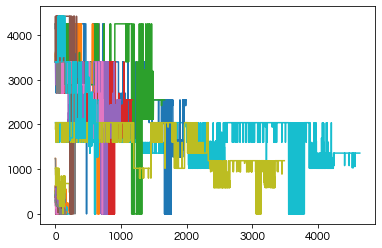

In [18]:
print(train_merged_data_pre[train_merged_data_pre.商品価格 <= 0].商品ID.nunique())
for ID in train_merged_data_pre[train_merged_data_pre.商品価格 <= 0].商品ID.unique():
    plt.plot(train_merged_data_pre[train_merged_data_pre.商品ID==ID].商品価格.values)

In [19]:
set(train_merged_data_pre[train_merged_data_pre.商品価格 <= 0].商品ID.unique()) & set(test.商品ID.unique())

set()

価格が0のものは30個しかない  
かつ, testデータにはその商品は存在しない

In [20]:
price_0_id = train_merged_data_pre[train_merged_data_pre.商品価格 <= 0].商品ID.unique()
price_0_id_df = pd.DataFrame(price_0_id, columns=['商品ID'])
idx_tbd = train_merged_data_pre['商品価格'] <= 0
#商品IDに対して, 0になったことがあるフラグ(何かと抱き合わせで購入される可能性がある)
# price_0_id_df['商品価格_is_0'] = idx_tbd.astype(int)
price_0_id_df['商品価格_is_0'] = 1

train_merged_data_pre = pd.merge(train_merged_data_pre, price_0_id_df, on='商品ID', how='left')
train_merged_data_pre['商品価格_is_0'] = train_merged_data_pre['商品価格_is_0'].fillna(0).astype(int)
train_merged_data_pre = train_merged_data_pre[train_merged_data_pre["商品価格"] > 0]

In [21]:
train_merged_data_pre[train_merged_data_pre['商品価格'] <= 0]

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0


## 売上個数0以下

In [23]:
# 0以下の値
train_merged_data_pre[train_merged_data_pre.売上個数<=0].売上個数.unique()

array([-1., -2., -4., -3.])

In [24]:
train_merged_data_pre[train_merged_data_pre.売上個数<=0]

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0
148,2018-01-01,1,1000487,1440,-1.0,100,映画 - DVD,2018,01,01,2018,1,1,0,0
580,2018-01-01,0,1500008,4760,-1.0,150,ゲーム - ゲーム機B,2018,01,01,2018,1,1,0,0
651,2018-01-01,1,1800005,2090,-1.0,180,ギフト - フィギュア,2018,01,01,2018,1,1,0,0
734,2018-01-01,0,2200029,510,-1.0,220,ゲーム - ゲーム機A,2018,01,01,2018,1,1,0,0
793,2018-01-01,9,2600022,2550,-1.0,260,ギフト - ガジェット類,2018,01,01,2018,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118133,2019-10-30,12,1800153,2380,-1.0,180,ギフト - フィギュア,2019,10,30,2019,10,30,21,0
1118181,2019-10-30,6,2000179,2290,-1.0,200,映画 - ブルーレイ3D,2019,10,30,2019,10,30,21,0
1118408,2019-10-31,8,1001872,250,-1.0,100,映画 - DVD,2019,10,31,2019,10,31,21,0
1118435,2019-10-31,13,1002350,250,-1.0,100,映画 - DVD,2019,10,31,2019,10,31,21,0


返品?, 入力ミス？

In [26]:
for index,data in train_merged_data_pre[train_merged_data_pre.売上個数<0][['月ブロック', '店舗ID', '商品ID', '売上個数']][:5].iterrows():
    print('index', index)
    display(train_merged_data_pre[(train_merged_data_pre.月ブロック==data[0])&(train_merged_data_pre.店舗ID==data[1])&(train_merged_data_pre.商品ID==data[2])])
    print('*'*100)

index 148


,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0
148,2018-01-01,1,1000487,1440,-1.0,100,映画 - DVD,2018,01,01,2018,1,1,0,0


****************************************************************************************************
index 580


,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0
580,2018-01-01,0,1500008,4760,-1.0,150,ゲーム - ゲーム機B,2018,01,01,2018,1,1,0,0
6700,2018-01-03,0,1500008,3500,2.0,150,ゲーム - ゲーム機B,2018,01,03,2018,1,3,0,0
6702,2018-01-03,0,1500008,4760,1.0,150,ゲーム - ゲーム機B,2018,01,03,2018,1,3,0,0
6703,2018-01-03,0,1500008,4760,2.0,150,ゲーム - ゲーム機B,2018,01,03,2018,1,3,0,0
9829,2018-01-04,0,1500008,3500,1.0,150,ゲーム - ゲーム機B,2018,01,04,2018,1,4,0,0
15637,2018-01-06,0,1500008,4760,1.0,150,ゲーム - ゲーム機B,2018,01,06,2018,1,6,0,0
20556,2018-01-08,0,1500008,4760,1.0,150,ゲーム - ゲーム機B,2018,01,08,2018,1,8,0,0
23791,2018-01-10,0,1500008,3500,1.0,150,ゲーム - ゲーム機B,2018,01,10,2018,1,10,0,0
40429,2018-01-19,0,1500008,4760,1.0,150,ゲーム - ゲーム機B,2018,01,19,2018,1,19,0,0
43070,2018-01-20,0,1500008,4760,-1.0,150,ゲーム - ゲーム機B,2018,01,20,2018,1,20,0,0


****************************************************************************************************
index 651


,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0
651,2018-01-01,1,1800005,2090,-1.0,180,ギフト - フィギュア,2018,01,01,2018,1,1,0,0
6943,2018-01-03,1,1800005,2090,1.0,180,ギフト - フィギュア,2018,01,03,2018,1,3,0,0


****************************************************************************************************
index 734


,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0
734,2018-01-01,0,2200029,510,-1.0,220,ゲーム - ゲーム機A,2018,01,01,2018,1,1,0,0
736,2018-01-01,0,2200029,760,2.0,220,ゲーム - ゲーム機A,2018,01,01,2018,1,1,0,0
3954,2018-01-02,0,2200029,850,3.0,220,ゲーム - ゲーム機A,2018,01,02,2018,1,2,0,0
16133,2018-01-06,0,2200029,1020,1.0,220,ゲーム - ゲーム機A,2018,01,06,2018,1,6,0,0
30483,2018-01-13,0,2200029,1020,1.0,220,ゲーム - ゲーム機A,2018,01,13,2018,1,13,0,0
43437,2018-01-20,0,2200029,1020,1.0,220,ゲーム - ゲーム機A,2018,01,20,2018,1,20,0,0
49033,2018-01-24,0,2200029,820,1.0,220,ゲーム - ゲーム機A,2018,01,24,2018,1,24,0,0
50928,2018-01-25,0,2200029,510,1.0,220,ゲーム - ゲーム機A,2018,01,25,2018,1,25,0,0
53657,2018-01-26,0,2200029,820,2.0,220,ゲーム - ゲーム機A,2018,01,26,2018,1,26,0,0
57701,2018-01-28,0,2200029,820,1.0,220,ゲーム - ゲーム機A,2018,01,28,2018,1,28,0,0


****************************************************************************************************
index 793


,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0
793,2018-01-01,9,2600022,2550,-1.0,260,ギフト - ガジェット類,2018,01,01,2018,1,1,0,0
7511,2018-01-03,9,2600022,2550,1.0,260,ギフト - ガジェット類,2018,01,03,2018,1,3,0,0


****************************************************************************************************


同じ年月/店ID/商品IDの中央値をこの誤った値に代入します。

In [28]:
ts = time.time()
with tqdm(total=len(train_merged_data_pre[train_merged_data_pre.売上個数<0])) as pbar:
    for index,data in train_merged_data_pre[train_merged_data_pre.売上個数<0][['月ブロック', '店舗ID', '商品ID', '売上個数']].iterrows():
        median = train_merged_data_pre[(train_merged_data_pre.売上個数>=0) & (train_merged_data_pre.月ブロック==data[0])&(train_merged_data_pre.店舗ID==data[1])&(train_merged_data_pre.商品ID==data[2])].売上個数.median()
        if math.isnan(median):
            train_merged_data_pre.loc[index, '売上個数'] = 0.0
        else:
            train_merged_data_pre.loc[index, '売上個数'] = median

        pbar.update(1)
time.time() - ts

  0%|          | 0/2670 [00:00<?, ?it/s]

222.76359295845032

In [30]:
train_merged_data_pre[train_merged_data_pre.売上個数 < 0]

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0


In [29]:
train_merged_data_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117299 entries, 0 to 1119569
Data columns (total 15 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   日付         1117299 non-null  datetime64[ns]
 1   店舗ID       1117299 non-null  object        
 2   商品ID       1117299 non-null  object        
 3   商品価格       1117299 non-null  int64         
 4   売上個数       1117299 non-null  float64       
 5   商品カテゴリID   1117299 non-null  object        
 6   商品カテゴリ名    1117299 non-null  object        
 7   year_cat   1117299 non-null  object        
 8   month_cat  1117299 non-null  object        
 9   day_cat    1117299 non-null  object        
 10  year       1117299 non-null  int64         
 11  month      1117299 non-null  int64         
 12  day        1117299 non-null  int64         
 13  月ブロック      1117299 non-null  int64         
 14  商品価格_is_0  1117299 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), objec

# 外れ値の確認/除外

In [34]:
# 外れ値の除外
train_merged_data_pre = train_merged_data_pre[train_merged_data_pre.商品価格 <= 100000]

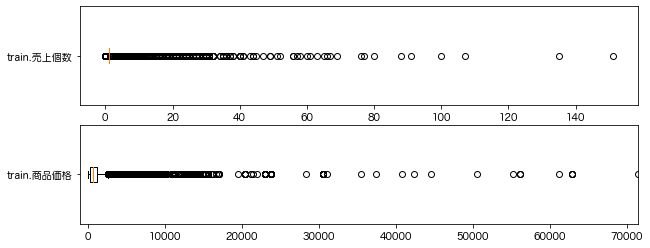

In [35]:
# trainデータにて、「製品の個数」を箱ひげ図で確認する
fig,ax = plt.subplots(2,1,figsize=(10,4))
# 尺度の調整
plt.xlim(-300, train_merged_data_pre.売上個数.max())
# 箱ひげ図を描画
ax[0].boxplot((train_merged_data_pre.売上個数) , labels=['train.売上個数'], vert=False)

# trainデータにて、「商品の価格」を箱ひげ図で確認する
plt.xlim(-1000, train_merged_data_pre.商品価格.max())
ax[1].boxplot((train_merged_data_pre.商品価格) , labels=['train.商品価格'], vert=False)
plt.show()

<AxesSubplot:xlabel='商品価格', ylabel='売上個数'>

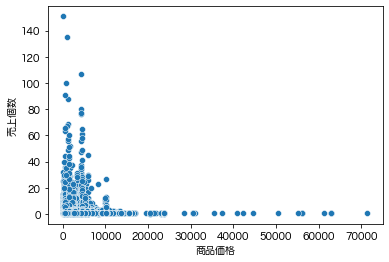

In [36]:
sns.scatterplot(x="商品価格", y="売上個数", data=train_merged_data_pre)

## 商品価格

<AxesSubplot:xlabel='商品価格', ylabel='Density'>

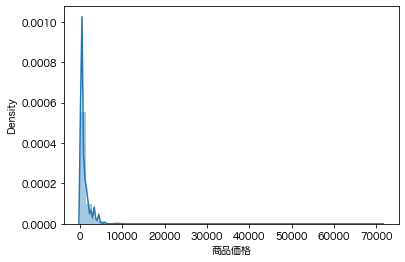

In [37]:
sns.distplot(train_merged_data_pre.商品価格)

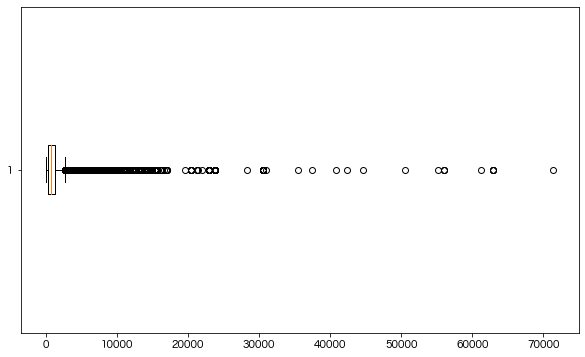

In [38]:
plt.figure(figsize=(10,6))
plt.boxplot(train_merged_data_pre["商品価格"],vert=False)
plt.show()

In [39]:
train_merged_data_pre[['商品価格']].describe()

,商品価格
count,1.117298e+06
mean,1.051091e+03
std,1.156912e+03
min,2.000000e+01
25%,3.400000e+02
50%,6.800000e+02
75%,1.270000e+03
max,7.140000e+04


In [40]:
train_merged_data_pre_201812[['商品価格']].describe()

,商品価格
count,72278.000000
mean,1197.077811
std,2301.850652
min,20.000000
25%,420.000000
50%,680.000000
75%,1530.000000
max,523570.000000


In [41]:
q = train_merged_data_pre.商品価格.quantile(0.95)
q

3400.0

In [42]:
q = train_merged_data_pre_201812.商品価格.quantile(0.95)
q

3740.0

## 売上個数

<AxesSubplot:xlabel='売上個数', ylabel='Density'>

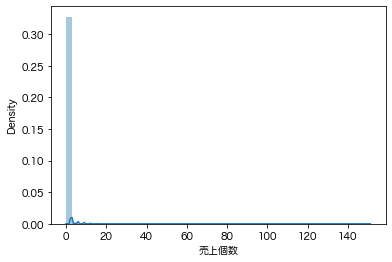

In [43]:
sns.distplot(train_merged_data_pre.売上個数)

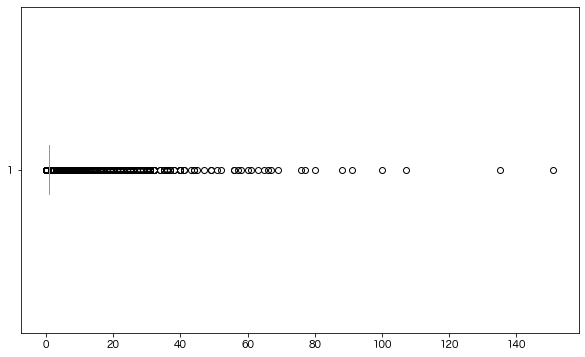

In [44]:
plt.figure(figsize=(10,6))
plt.boxplot(train_merged_data_pre["売上個数"],vert=False)
plt.show()

In [45]:
train_merged_data_pre[['売上個数']].describe()

,売上個数
count,1.117298e+06
mean,1.132415e+00
std,7.822413e-01
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.510000e+02


In [46]:
train_merged_data_pre_201812[['売上個数']].describe()

,売上個数
count,72278.000000
mean,1.164047
std,0.650796
min,-1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,30.000000


In [47]:
q = train_merged_data_pre.売上個数.quantile(0.95)
q

2.0

In [48]:
q = train_merged_data_pre_201812.売上個数.quantile(0.95)
q

2.0

# データの保存

In [50]:
# train_merged_data_pre.to_pickle('./inputs/train_merged_data_pre.pickle')

In [12]:
train_merged_data_pre = pd.read_pickle('./inputs/train_merged_data_pre.pickle')

# 基本の特徴量の追加

In [13]:
train_merged_data = train_merged_data_pre.copy()

## 祝日情報

In [14]:
train_merged_data = pd.merge(train_merged_data, syukujitsu_df, on="日付", how="left")
train_merged_data["holiday"].fillna(0, inplace=True)
train_merged_data.loc[~(train_merged_data.holiday == 0), "holiday"] = 1
train_merged_data["holiday_cat"] = train_merged_data["holiday"].astype(str)
# del syukujitsu_df

## 日付情報

In [15]:
def get_day_of_week_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

In [16]:
train_merged_data['weekday_cat'] = train_merged_data['日付'].apply(lambda x : get_day_of_week_jp(x))
train_merged_data['weekday'] = train_merged_data['日付'].apply(lambda x : x.weekday())

## 商品カテゴリー

In [17]:
category = train_merged_data["商品カテゴリ名"].apply(lambda text : text.split('-'))
category_list = list(category)
train_merged_data[["商品カテゴリ_type1", '商品カテゴリ名_tmp']] = category_list

train_merged_data['商品カテゴリ_type2']  = train_merged_data['商品カテゴリ名_tmp'].str.split("_", expand=True)[0]
train_merged_data['商品カテゴリ_type3']  = train_merged_data['商品カテゴリ名_tmp'].str.split("_", expand=True)[1]
train_merged_data = train_merged_data.drop(columns='商品カテゴリ名_tmp')

## sin, cosへの変換

In [59]:
def encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [60]:
train_merged_data = encode(train_merged_data, 'month')
train_merged_data = encode(train_merged_data, 'weekday')
train_merged_data = encode(train_merged_data, 'day')

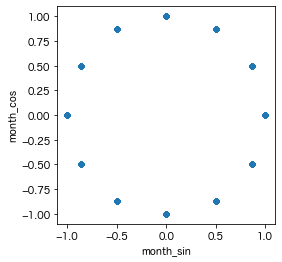

In [61]:
# 例：月の循環性
train_merged_data.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

## 売上金額

In [62]:
train_merged_data['売上金額'] = train_merged_data['商品価格'] * train_merged_data['売上個数']

# データ確認

In [64]:
train_merged_data.tail()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,year_cat,month_cat,day_cat,year,month,day,月ブロック,商品価格_is_0,holiday,holiday_cat,weekday_cat,weekday,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,month_cos,month_sin,weekday_cos,weekday_sin,day_cos,day_sin,売上金額
1117293,2019-10-31,8,3400006,2700,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10,31,2019,10,31,21,0,0,0,木曜日,3,ゲーム周辺機器,ゲーム機A,None,0.5,-0.866025,-1.0,1.224647e-16,1.0,-2.449294e-16,2700.0
1117294,2019-10-31,7,3400009,1020,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10,31,2019,10,31,21,0,0,0,木曜日,3,ゲーム周辺機器,ゲーム機A,None,0.5,-0.866025,-1.0,1.224647e-16,1.0,-2.449294e-16,1020.0
1117295,2019-10-31,7,3400012,510,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10,31,2019,10,31,21,0,0,0,木曜日,3,ゲーム周辺機器,ゲーム機A,None,0.5,-0.866025,-1.0,1.224647e-16,1.0,-2.449294e-16,510.0
1117296,2019-10-31,4,3500001,340,1.0,350,本 - オーディオブック_タイプB,2019,10,31,2019,10,31,21,0,0,0,木曜日,3,本,オーディオブック,タイプB,0.5,-0.866025,-1.0,1.224647e-16,1.0,-2.449294e-16,340.0
1117297,2019-10-31,13,3500004,420,1.0,350,本 - オーディオブック_タイプB,2019,10,31,2019,10,31,21,0,0,0,木曜日,3,本,オーディオブック,タイプB,0.5,-0.866025,-1.0,1.224647e-16,1.0,-2.449294e-16,420.0


## 型

In [65]:
cat_col = [col for col in train_merged_data.select_dtypes(include=object)]
num_col = [col for col in train_merged_data.select_dtypes(exclude=object)]

# 1日データの保存

In [66]:
# train_merged_data.to_pickle('./inputs/train_merged_data.pickle')

In [18]:
train_merged_data = pd.read_pickle('./inputs/train_merged_data.pickle')

# 前処理

## 「'月'、'商品ID'、 '店舗ID'」の全組み合わせを作成する

salesデータには、売上が0個の場合の履歴が含まれていない。
そのため、モデルに『売上が0個となる』場合を正しく学習させるには、新たにデータを生成する必要がある。
ここでは、「月」×「商品ID」×「店舗ID」の組み合わせを生成し、元のデータと統合することで、『売上が0個となる』場合も含めた売上履歴データの生成を試みる。

In [19]:
all_combination = []

# ['月ブロック',  '店舗ID', '商品ID']の全組み合わせを作成する
columns = ['月ブロック',  '店舗ID', '商品ID']

for i in range(train_merged_data['月ブロック'].nunique()):
    train_block = train_merged_data[train_merged_data['月ブロック']==i]
    all_combination.append(np.array(list(product([i], train_block['店舗ID'].unique(), train_block['商品ID'].unique()))))
    
all_combination = pd.DataFrame(np.vstack(all_combination), columns=columns)
all_combination['月ブロック'] = all_combination['月ブロック'].astype(int)
all_combination.sort_values(columns, inplace=True)


# print(all_combination.info())
all_combination

,月ブロック,店舗ID,商品ID
13860,0,0,1000001
14478,0,0,1000002
16299,0,0,1000003
14479,0,0,1000004
14480,0,0,1000005
...,...,...,...
1623336,21,9,3500063
1624488,21,9,3500070
1625866,21,9,3500071
1625342,21,9,3500072


## 月ごとの目的変数(売上)を集計する

ここからは、モデルの学習を行うためのデータセットの作成作業に入る。
『各店舗』×『各商品』の組み合わせについて、『2019年12月の1ヶ月間』における『合計売上個数』を予測する
というのが今回のタスクであるため、学習用データをそれに従って再構成する。

In [20]:
# 「月ブロック」「商品ID」「店舗ID」でグルーピングし、売上個数の合計を取る
gp_month = train_merged_data.groupby(['月ブロック', '店舗ID', '商品ID']).agg({'商品価格':['sum', 'mean'], '売上個数':['sum', 'mean','count']}).reset_index()
gp_month.columns = ["".join(c) for c in gp_month.columns]
gp_month = gp_month.rename(columns={'売上個数sum':'売上個数'})
gp_month

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,売上個数count
0,0,0,1000001,2100,420.0,6.0,1.2,5
1,0,0,1000002,500,250.0,2.0,1.0,2
2,0,0,1000004,120,120.0,1.0,1.0,1
3,0,0,1000005,1760,220.0,8.0,1.0,8
4,0,0,1000006,380,190.0,2.0,1.0,2
...,...,...,...,...,...,...,...,...
494639,21,9,3400006,5400,2700.0,2.0,1.0,2
494640,21,9,3400012,680,680.0,1.0,1.0,1
494641,21,9,3500002,510,510.0,1.0,1.0,1
494642,21,9,3500003,420,420.0,1.0,1.0,1


In [21]:
# all_combinationに売上履歴データを追加する
all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '店舗ID', '商品ID'], how='left')

convert_columns = gp_month.columns[3:]
print(convert_columns)
# 売上個数がNaNとなっている箇所は、売上個数0個として値を埋める
all_train[convert_columns] = all_train[convert_columns].fillna(0).astype(np.float16) # 0で穴埋めする, # 型のキャスト
all_train.rename(columns={'売上個数count':'購買回数'}, inplace=True)
all_train['購買回数'] = all_train['購買回数'].astype(int)

Index(['商品価格sum', '商品価格mean', '売上個数', '売上個数mean', '売上個数count'], dtype='object')


In [23]:
new_test12 = test.copy()
# 評価対象期間が2019年10月(月ブロック: 21)であるという情報を追加
new_test12['月ブロック'] = 21
new_test12 = new_test12.drop(columns = 'index')

#tesuデータにしかない商品IDを追加
test_less_list = set(new_test12.商品ID.unique()) - set(all_train[all_train.月ブロック == 21].商品ID.unique())
new_test12 = new_test12[new_test12.商品ID.isin(test_less_list)]

all_train = pd.concat([all_train, new_test12])

In [24]:
# all_train[(all_train.月ブロック == 9) & (all_train.店舗ID == '9')]
all_train

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0
...,...,...,...,...,...,...,...,...
2893,21,13,3000001,NaN,NaN,NaN,NaN,NaN
2894,21,14,3000001,NaN,NaN,NaN,NaN,NaN
2895,21,15,3000001,NaN,NaN,NaN,NaN,NaN
2896,21,16,3000001,NaN,NaN,NaN,NaN,NaN


### ラベルの作成

予測の問題を扱っているので、ラベルは2ヶ月先の「売上個数」とします。

In [25]:
def future_feature(df, futures, col):
    tmp = df[['月ブロック','商品ID','店舗ID',col]]
    for i in tqdm(futures):
        shifted = tmp.copy()
        # 列名の更新
        shifted.columns = ['月ブロック','商品ID','店舗ID', col+'_future_'+str(i)]
        shifted['月ブロック'] -= i
    return shifted

In [26]:
shifted = future_feature(all_train, [2], '売上個数')
shifted = shifted.rename(columns={'売上個数_future_2':'売上個数_2month'})
dataset = pd.merge(all_train, shifted, on=['月ブロック','商品ID','店舗ID'], how='left')

dataset_train = dataset[dataset['月ブロック'] != 21]
dataset_train['売上個数_2month'] = dataset_train['売上個数_2month'].fillna(0)
dataset_test = dataset[dataset['月ブロック'] == 21]

dataset = pd.concat([dataset_train, dataset_test])
del dataset_train
del dataset_test

dataset

  0%|          | 0/1 [00:00<?, ?it/s]

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0,1.0
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0,1.0
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0,0.0
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0,2.0
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0,2.0
...,...,...,...,...,...,...,...,...,...
1648543,21,13,3000001,NaN,NaN,NaN,NaN,NaN,NaN
1648544,21,14,3000001,NaN,NaN,NaN,NaN,NaN,NaN
1648545,21,15,3000001,NaN,NaN,NaN,NaN,NaN,NaN
1648546,21,16,3000001,NaN,NaN,NaN,NaN,NaN,NaN


# 特徴量生成

## 変換・追加型の特徴量

### 「年・月」情報の追加

In [27]:
dataset_addfeature = pd.merge(dataset, gp_time, on='月ブロック', how='left')

In [28]:
dataset_addfeature

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0,1.0,2018,01
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0,1.0,2018,01
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0,0.0,2018,01
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0,2.0,2018,01
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0,2.0,2018,01
...,...,...,...,...,...,...,...,...,...,...,...
1648543,21,13,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10
1648544,21,14,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10
1648545,21,15,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10
1648546,21,16,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10


### 文字列データを数値データに直す

In [29]:
dataset_addfeature['year'] = dataset_addfeature['year_cat'].astype(int)
dataset_addfeature['month'] = dataset_addfeature['month_cat'].astype(int)

### 月ブロック_catを追加

In [30]:
dataset_addfeature['月ブロック_cat'] = dataset_addfeature['月ブロック'].astype(str)

### sin, cosへの変換

In [31]:
def encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [32]:
dataset_addfeature = encode(dataset_addfeature, 'month')

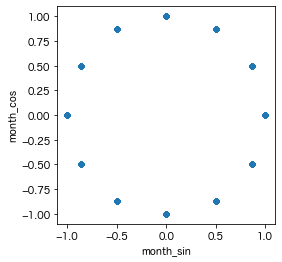

In [33]:
# 例：月の循環性
dataset_addfeature.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

### 「祝日の数」情報の追加

In [34]:
syukujitsu_df = syukujitsu_df[syukujitsu_df['日付'] >= '2018-01-01']
syukujitsu_df[['year_cat', 'month_cat', 'day_cat']] = list(map(lambda text:text.split('-'), syukujitsu_df["日付"].astype(str)))
syukujitsu_df[['year', 'month', 'day']] = syukujitsu_df[['year_cat', 'month_cat', 'day_cat']] .astype(int)
syukujitsu_df['holiday_flag'] = 1

In [35]:
group = syukujitsu_df.groupby(['year_cat', 'month_cat']).agg({'holiday_flag': np.sum}).reset_index()
dataset_addfeature = pd.merge(dataset_addfeature, group, on=['year_cat', 'month_cat'], how='left')
dataset_addfeature = dataset_addfeature.fillna({'holiday_flag': 0})
dataset_addfeature['holiday_flag'] = dataset_addfeature['holiday_flag'].astype(int)
dataset_addfeature.rename(columns={'holiday_flag':'holiday_cnt'}, inplace=True)

In [36]:
dataset_addfeature

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0,0.0,2018,01,2018,1,0,0.866025,0.500000,2
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648543,21,13,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2
1648544,21,14,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2
1648545,21,15,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2
1648546,21,16,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2


### 「曜日」情報の追加

In [37]:
group = train_merged_data.groupby(['月ブロック','日付','weekday_cat']).agg({'weekday_cat':['count']}).reset_index()
group.columns = ['月ブロック', '日付', '曜日', '曜日cnt']
group = group[['月ブロック', '日付', '曜日']]
group = group.groupby(['月ブロック','曜日']).agg({'曜日':['count']}).reset_index()
group.columns = ['月ブロック', 'weekday_cat', 'weekday_cat_cnt']

In [38]:
for w in group.weekday_cat.unique():
    week_group = group[group.weekday_cat == w]
    week_group = week_group.rename(columns={'weekday_cat_cnt':f'{w}_cnt'})
    week_group = week_group.drop('weekday_cat', axis=1)
    dataset_addfeature = pd.merge(dataset_addfeature, week_group, on=['月ブロック'], how='left')

In [39]:
dataset_addfeature

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0,0.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648543,21,13,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4
1648544,21,14,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4
1648545,21,15,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4
1648546,21,16,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4


#### 単品価格

In [40]:
dataset_addfeature['item_price_unit'] = dataset_addfeature['商品価格sum'] // dataset_addfeature['売上個数']
dataset_addfeature['item_price_unit'].fillna(0, inplace=True)

In [41]:
dataset_addfeature

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,350.0
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,250.0
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0,0.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,0.0
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,120.0
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,220.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648543,21,13,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0
1648544,21,14,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0
1648545,21,15,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0
1648546,21,16,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0


### 「商品カテゴリID」「商品カテゴリ名」情報の追加

In [42]:
ts = time.time()
dataset_addfeature = pd.merge(dataset_addfeature, cats, on='商品ID', how='left')
dataset_addfeature = pd.merge(dataset_addfeature, cat_names, on='商品カテゴリID', how='left')

category = dataset_addfeature["商品カテゴリ名"].apply(lambda text : text.split('-'))
category_list = list(category)
dataset_addfeature[["商品カテゴリ_type1", '商品カテゴリ名_tmp']] = category_list

dataset_addfeature['商品カテゴリ_type2']  = dataset_addfeature['商品カテゴリ名_tmp'].str.split("_", expand=True)[0]
dataset_addfeature['商品カテゴリ_type3']  = dataset_addfeature['商品カテゴリ名_tmp'].str.split("_", expand=True)[1]
dataset_addfeature = dataset_addfeature.drop(columns='商品カテゴリ名_tmp')
time.time() - ts

6.553478956222534

In [43]:
item_categories_addname = pd.read_pickle('./inputs/item_categories_addname.pickle')
category = item_categories_addname["商品カテゴリ名"].apply(lambda text : text.split('-'))
category_list = list(category)
item_categories_addname[["商品カテゴリ_type1", '商品カテゴリ名_tmp']] = category_list
item_categories_addname['商品カテゴリ_type2']  = item_categories_addname['商品カテゴリ名_tmp'].str.split("_", expand=True)[0]
item_categories_addname['商品カテゴリ_type3']  = item_categories_addname['商品カテゴリ名_tmp'].str.split("_", expand=True)[1]
item_categories_addname = item_categories_addname.drop(columns='商品カテゴリ名_tmp')

In [44]:
group = item_categories_addname.groupby(['商品カテゴリ名']).agg({'商品ID':['count']})
group.columns = ['カテゴリ内_商品数']
group.reset_index(inplace=True)
dataset_addfeature = pd.merge(dataset_addfeature, group, on='商品カテゴリ名', how='left')

In [45]:
group = item_categories_addname.groupby(['商品カテゴリ_type1']).agg({'商品ID':['count']})
group.columns = ['カテゴリtype1内_商品数']
group.reset_index(inplace=True)
dataset_addfeature = pd.merge(dataset_addfeature, group, on='商品カテゴリ_type1', how='left')

In [46]:
group = item_categories_addname.groupby(['商品カテゴリ_type2']).agg({'商品ID':['count']})
group.columns = ['カテゴリtype2内_商品数']
group.reset_index(inplace=True)
dataset_addfeature = pd.merge(dataset_addfeature, group, on='商品カテゴリ_type2', how='left')

In [47]:
group = item_categories_addname.groupby(['商品カテゴリ_type3']).agg({'商品ID':['count']})
group.columns = ['カテゴリtype3内_商品数']
group.reset_index(inplace=True)
dataset_addfeature = pd.merge(dataset_addfeature, group, on='商品カテゴリ_type3', how='left')

In [48]:
del item_categories_addname

### あるワードがカテゴリ内に入っているかどうか

In [49]:
dataset_addfeature['商品カテゴリ名_contains_ゲーム'] = np.where(dataset_addfeature['商品カテゴリ名'].str.contains('ゲーム'), 1, 0)
dataset_addfeature['商品カテゴリ名_contains_PC'] = np.where(dataset_addfeature['商品カテゴリ名'].str.contains('PC'), 1, 0)

In [50]:
# dataset_addfeature.to_pickle('./inputs/dataset_addfeature.pickle')

## 集約型の特徴量

In [51]:
dataset_addfeature_lag = dataset_addfeature.copy()

### 商品の最安値・最高値

In [52]:
gp_item_price = train_merged_data.sort_values('月ブロック').groupby(['月ブロック','商品ID'], as_index=False).agg({'商品価格':[np.min, np.max]})
gp_item_price.columns = ['月ブロック','商品ID', 'hist_min_item_price', 'hist_max_item_price']
dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, gp_item_price, on=['月ブロック','商品ID'], how='left')

In [53]:
gp_item_price = train_merged_data.sort_values('月ブロック').groupby(['月ブロック','店舗ID', '商品ID'], as_index=False).agg({'商品価格':[np.min, np.max]})
gp_item_price.columns = ['月ブロック', '店舗ID', '商品ID','hist_min_shop_item_price', 'hist_max_shop_item_price']
gp_item_price[['hist_min_shop_item_price', 'hist_max_shop_item_price']] = gp_item_price[['hist_min_shop_item_price', 'hist_max_shop_item_price']].fillna(0)
dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, gp_item_price, on=['月ブロック','店舗ID', '商品ID'], how='left')

In [54]:
dataset_addfeature_lag.head()

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,hist_min_item_price,hist_max_item_price,hist_min_shop_item_price,hist_max_shop_item_price
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0,1.0,2018,01,2018,1,0,0.866025,0.5,2,4,4,5,4,5,5,4,350.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,230.0,420.0,420.0,420.0
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0,1.0,2018,01,2018,1,0,0.866025,0.5,2,4,4,5,4,5,5,4,250.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,100.0,250.0,250.0,250.0
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0,0.0,2018,01,2018,1,0,0.866025,0.5,2,4,4,5,4,5,5,4,0.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,250.0,250.0,NaN,NaN
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0,2.0,2018,01,2018,1,0,0.866025,0.5,2,4,4,5,4,5,5,4,120.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,120.0,250.0,120.0,120.0
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0,2.0,2018,01,2018,1,0,0.866025,0.5,2,4,4,5,4,5,5,4,220.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,130.0,250.0,130.0,250.0


#### 各アイテムの価格が、過去の（最低／最高）価格からどれだけ変化したか。

In [55]:
dataset_addfeature_lag['item_price_increase'] = dataset_addfeature_lag['商品価格mean'] / dataset_addfeature_lag['hist_min_item_price']
dataset_addfeature_lag['item_price_decrease'] = dataset_addfeature_lag['hist_max_item_price'] / dataset_addfeature_lag['商品価格mean'] 

dataset_addfeature_lag['shop_item_price_increase'] = dataset_addfeature_lag['商品価格mean'] / dataset_addfeature_lag['hist_min_shop_item_price']
dataset_addfeature_lag['shop_item_price_decrease'] = dataset_addfeature_lag['hist_max_shop_item_price'] / dataset_addfeature_lag['商品価格mean'] 

dataset_addfeature_lag['item_price_min_increase'] = dataset_addfeature_lag['hist_min_shop_item_price'] / dataset_addfeature_lag['hist_min_item_price']
dataset_addfeature_lag['item_price_max_increase'] = dataset_addfeature_lag['hist_max_shop_item_price'] / dataset_addfeature_lag['hist_max_item_price'] 

dataset_addfeature_lag = dataset_addfeature_lag.replace([np.inf, -np.inf], np.nan)

#### Rolling window based features (window = 3 months).

In [56]:
ts = time.time()
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    dataset_addfeature_lag[('item_cnt_%s' % function_name[i])] = dataset_addfeature_lag.sort_values('月ブロック').groupby(['店舗ID', '商品カテゴリID', '商品ID'])['売上個数'].apply(function_list[i])
    dataset_addfeature_lag[('item_price_%s' % function_name[i])] = dataset_addfeature_lag.sort_values('月ブロック').groupby(['店舗ID', '商品カテゴリID', '商品ID'])['商品価格mean'].apply(function_list[i])
    
# Fill the empty std features with 0
dataset_addfeature_lag['item_cnt_std'].fillna(0, inplace=True)
dataset_addfeature_lag['item_price_std'].fillna(0, inplace=True)
time.time() - ts

100.11261224746704

In [57]:
dataset_addfeature_lag

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,hist_min_item_price,hist_max_item_price,hist_min_shop_item_price,hist_max_shop_item_price,item_price_increase,item_price_decrease,shop_item_price_increase,shop_item_price_decrease,item_price_min_increase,item_price_max_increase,item_cnt_min,item_price_min,item_cnt_max,item_price_max,item_cnt_mean,item_price_mean,item_cnt_std,item_price_std
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,350.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,230.0,420.0,420.0,420.0,1.826087,1.000000,1.000000,1.000000,1.826087,1.00,6.0,420.0,6.0,420.0,6.0,420.0,0.000000e+00,0.000000
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,250.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,100.0,250.0,250.0,250.0,2.500000,1.000000,1.000000,1.000000,2.500000,1.00,2.0,250.0,2.0,250.0,2.0,250.0,0.000000e+00,0.000000
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0,0.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,0.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,250.0,250.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,120.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,120.0,250.0,120.0,120.0,1.000000,2.083333,1.000000,1.000000,1.000000,0.48,1.0,120.0,1.0,120.0,1.0,120.0,0.000000e+00,0.000000
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,220.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,130.0,250.0,130.0,250.0,1.692308,1.136364,1.692308,1.136364,1.000000,1.00,8.0,220.0,8.0,220.0,8.0,220.0,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648543,21,13,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0,300,本 - 教育用,本,教育用,None,88,445,88,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.107342e-08,0.000000
1648544,21,14,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0,300,本 - 教育用,本,教育用,None,88,445,88,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.053671e-08,0.000000
1648545,21,15,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0,300,本 - 教育用,本,教育用,None,88,445,88,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.053671e-08,0.000000
1648546,21,16,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0,300,本 - 教育用,本,教育用,None,88,445,88,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,600.0,0.5,300.0,7.071068e-01,424.264069


### ラグ特徴量の作成

昨年度同月の売上個数が今年度の売上個数の予測に役立つのではないかという仮説のもとに、ラグ特徴量を生成する  
ここでは、月ブロックを1年分(12)ずらした上でデータを統合するという方法を取る。

In [58]:
def lag_feature(df, lags, col):
    tmp = df[['月ブロック','商品ID','店舗ID',col]]
    for i in tqdm(lags):
        shifted = tmp.copy()
        # 列名の更新
        shifted.columns = ['月ブロック','商品ID','店舗ID', col+'_lag_'+str(i)]
        shifted['月ブロック'] += i
        df = pd.merge(df, shifted, on=['月ブロック','商品ID','店舗ID'], how='left')
    return df

In [59]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12]

#### Traget lags(nヶ月前の売上個数を特徴量に追加)

In [60]:
ts = time.time()
# lagsに格納された値のヶ月前の売上個数を特量量として追加する
dataset_addfeature_lag = lag_feature(dataset_addfeature, lags, '売上個数')
time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

10.339421033859253

#### 売上個数の平均値 標準値 最大値 最小値 のラグ特徴量

##### 月ブロック で絞った 月次売上個数のlag

In [61]:
ts = time.time()
group = dataset_addfeature_lag.groupby(['月ブロック']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[1:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)
time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

52.399739265441895

In [62]:
dataset_addfeature_lag

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12
0,0,0,1000001,2100.0,420.0,6.0,1.200195,5.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,350.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1000002,500.0,250.0,2.0,1.000000,2.0,1.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,250.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1000003,0.0,0.0,0.0,0.000000,0.0,0.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,0.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,1000004,120.0,120.0,1.0,1.000000,1.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,120.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,1000005,1760.0,220.0,8.0,1.000000,8.0,2.0,2018,01,2018,1,0,0.866025,0.500000,2,4,4,5,4,5,5,4,220.0,100,映画 - DVD,映画,DVD,None,2733,4186,2733,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648543,21,13,3000001,NaN,NaN,NaN,NaN,NaN,NaN,2019,10,2019,10,21,0.500000,-0.866025,2,4,4,4,5,5,5,4,0.0,300,本 - 教育用,本,教育用,None,88,445,88,NaN,0,0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0

##### 月ブロック と 商品ID で絞った 月次売上個数 のlag

In [63]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品ID']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_item".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品ID'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

66.05097508430481

##### 月ブロック と 店舗ID で絞った 月次売上個数 のlag

In [64]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '店舗ID']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_shop".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','店舗ID'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

78.54749178886414

##### 月ブロック と 商品カテゴリ名 で絞った 月次売上個数 のlag

In [65]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品カテゴリ名']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_catname".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品カテゴリ名'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

90.96231412887573

##### 月ブロック と 商品カテゴリ_type1 で絞った 月次売上個数 のlag

In [66]:

ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品カテゴリ_type1']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_itemcategory1".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品カテゴリ_type1'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

103.4363169670105

##### 月ブロック と 商品カテゴリ_type2 で絞った 月次売上個数 のlag

In [67]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品カテゴリ_type2']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_itemcategory2".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品カテゴリ_type2'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

115.6226019859314

##### 月ブロック と 商品カテゴリ_type3 で絞った 月次売上個数 のlag

In [68]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品カテゴリ_type3']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_itemcategory3".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品カテゴリ_type3'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

129.9534993171692

#### トレンドのラグ特徴量

##### 商品価格のトレンド

In [69]:
dataset_addfeature_lag_trend = dataset_addfeature_lag.copy()

In [70]:
def select_trend(row, lags=[1,2,3,4,5,6,12]):
        for i in lags:
            if row['delta_価格_lag_'+str(i)]:
                return row['delta_価格_lag_'+str(i)]
        return 0 
    
def cal_price_trend(original_df, group_column, add_df, lags=[1,2,3,4,5,6,12]):
    group = original_df.groupby([group_column]).agg({'商品価格': ['mean']})
    group.columns = ['商品平均価格']
    group.reset_index(inplace=True)
    add_df = pd.merge(add_df, group, on=[group_column], how='left')
    add_df['商品平均価格'] = add_df['商品平均価格'].astype(np.float16)

    group = original_df.groupby(['月ブロック', group_column]).agg({'商品価格': ['mean']})
    group.columns = ['月ブロック_商品平均価格']
    group.reset_index(inplace=True)
    add_df = pd.merge(add_df, group, on=['月ブロック', group_column], how='left')
    add_df['月ブロック_商品平均価格'] = add_df['月ブロック_商品平均価格'].astype(np.float16)

    add_df = lag_feature(add_df, lags, '月ブロック_商品平均価格')

#     for i in lags:
#         add_df['delta_価格_lag_'+str(i)] = \
#             (add_df['月ブロック_商品平均価格_lag_'+str(i)] - add_df['商品平均価格']) / add_df['商品平均価格']

#     add_df[f'delta_{group_column}_価格_lag'] = add_df.apply(select_trend, axis=1)
#     add_df[f'delta_{group_column}_価格_lag'] = add_df[f'delta_{group_column}_価格_lag'].astype(np.float16)
#     add_df[f'delta_{group_column}_価格_lag'].fillna(0, inplace=True)

#     fetures_to_drop = ['商品平均価格', '月ブロック_商品平均価格']
#     for i in lags:
#         fetures_to_drop += ['月ブロック_商品平均価格_lag_'+str(i)]
#         fetures_to_drop += ['delta_価格_lag_'+str(i)]
    '''    
    9/26 select_trendの意味がよくわからない, 全部特徴量でいいのでは？
    '''
    for i in lags:
        add_df[f'delta_{group_column}_価格_lag_'+str(i)] = \
            (add_df['月ブロック_商品平均価格_lag_'+str(i)] - add_df['商品平均価格']) / add_df['商品平均価格']
        add_df[f'delta_{group_column}_価格_lag_'+str(i)] = add_df[f'delta_{group_column}_価格_lag_'+str(i)].astype(np.float16)
        add_df[f'delta_{group_column}_価格_lag_'+str(i)].fillna(0, inplace=True)

        
    fetures_to_drop = ['商品平均価格', '月ブロック_商品平均価格']
    for i in lags:
        fetures_to_drop += ['月ブロック_商品平均価格_lag_'+str(i)]
    add_df.drop(fetures_to_drop, axis=1, inplace=True)
    
    return add_df

###### 商品IDごとの商品価格のトレンド

###### 店舗IDごとの商品価格のトレンド

###### カテゴリごとの商品価格のトレンド

In [71]:
group_columns = ['店舗ID', '商品ID', '商品カテゴリ名', '商品カテゴリ_type1', '商品カテゴリ_type2', '商品カテゴリ_type3']

for group_column in tqdm(group_columns):
    dataset_addfeature_lag_trend = cal_price_trend(train_merged_data, group_column, dataset_addfeature_lag_trend)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [72]:
group_max = train_merged_data.groupby(['月ブロック','商品ID']).agg({'商品価格': max}).reset_index()
group_max = group_max.rename(columns={'商品価格':'月ブロック_最高_商品価格'})

group_min = train_merged_data.groupby(['月ブロック','商品ID']).agg({'商品価格': min}).reset_index()
group_min = group_min.rename(columns={'商品価格':'月ブロック_最低_商品価格'})

dataset_addfeature_lag_trend =\
    pd.merge(dataset_addfeature_lag_trend, group_max, on=['月ブロック','商品ID'], how='left')

dataset_addfeature_lag_trend =\
    pd.merge(dataset_addfeature_lag_trend, group_min, on=['月ブロック','商品ID'], how='left')

dataset_addfeature_lag_trend['月ブロック_最高_商品価格'] =\
    dataset_addfeature_lag_trend['月ブロック_最高_商品価格'].astype(np.float16).fillna(0)

dataset_addfeature_lag_trend['月ブロック_最低_商品価格'] =\
    dataset_addfeature_lag_trend['月ブロック_最低_商品価格'].astype(np.float16).fillna(0)

dataset_addfeature_lag_trend['月ブロック_商品価格_セール度'] =\
    dataset_addfeature_lag_trend['月ブロック_最低_商品価格'] / dataset_addfeature_lag_trend['月ブロック_最高_商品価格']


dataset_addfeature_lag_trend = lag_feature(dataset_addfeature_lag_trend, lags, '月ブロック_商品価格_セール度')

fetures_to_drop = ['月ブロック_最高_商品価格', '月ブロック_最低_商品価格','月ブロック_商品価格_セール度']
dataset_addfeature_lag_trend.drop(fetures_to_drop, axis=1, inplace=True)


  0%|          | 0/12 [00:00<?, ?it/s]

#### 店ごとの売上金額のトレンド

In [73]:
def cal_sales_trend(original_df, group_column, add_df, lags=[1,2,3,4,5,6,12]):
    group = original_df.groupby(['月ブロック', group_column]).agg({'売上金額': ['sum']})
    group.columns = ['月ブロック_店舗別__合計売上金額']
    group.reset_index(inplace=True)
    add_df = pd.merge(add_df, group, on=['月ブロック', group_column], how='left')
    add_df['月ブロック_店舗別__合計売上金額'] = add_df['月ブロック_店舗別__合計売上金額'].astype(np.float32)
    
    group = group.groupby([group_column]).agg({'月ブロック_店舗別__合計売上金額': ['mean']})
    group.columns = ['店舗別_平均売上金額']
    group.reset_index(inplace=True)
    add_df = pd.merge(add_df, group, on=[group_column], how='left')
    add_df['店舗別_平均売上金額'] = add_df['店舗別_平均売上金額'].astype(np.float32)
    
    add_df[f'delta_{group_column}別_売上金額'] = (add_df['月ブロック_店舗別__合計売上金額'] - add_df['店舗別_平均売上金額']) / add_df['店舗別_平均売上金額']
    add_df[f'delta_{group_column}別_売上金額'] = add_df[f'delta_{group_column}別_売上金額'].astype(np.float16)

    add_df = lag_feature(add_df, lags, f'delta_{group_column}別_売上金額')

    add_df.drop(['月ブロック_店舗別__合計売上金額','店舗別_平均売上金額',f'delta_{group_column}別_売上金額'], axis=1, inplace=True)
    return add_df

##### 店舗IDごと の 売上金額 トレンド

##### 商品IDごと の 売上金額トレンド

##### 商品カテゴリごと の 売上金額トレンド

In [74]:
group_columns = ['店舗ID', '商品ID', '商品カテゴリ名', '商品カテゴリ_type1', '商品カテゴリ_type2', '商品カテゴリ_type3']

for group_column in tqdm(group_columns):
    dataset_addfeature_lag_trend = cal_sales_trend(train_merged_data, group_column, dataset_addfeature_lag_trend)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

### 商品価格が0の数

In [75]:
group = train_merged_data.groupby(['月ブロック', '商品ID'])['商品価格_is_0'].sum().reset_index()

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品ID'], how='left')
dataset_addfeature_lag['商品価格_is_0'] = dataset_addfeature_lag['商品価格_is_0'].fillna(0).astype(int)

## 他の特徴量

### 月が何日あるか

In [76]:
days = pd.Series([0,31,28,31,30,31,30,31,31,30,31,30,31])
dataset_addfeature_lag_trend['days'] = dataset_addfeature_lag_trend['month'].map(days).astype(np.int8)

### 発売日

In [77]:
ts = time.time()
cache = {}
dataset_addfeature_lag_trend['item_shop_last_sale'] = -1
dataset_addfeature_lag_trend['item_shop_last_sale'] = dataset_addfeature_lag_trend['item_shop_last_sale'].astype(np.int8)

for idx, row in dataset_addfeature_lag_trend.iterrows():    
    key = str(row.商品ID)+' '+str(row.店舗ID)
    if key not in cache:
        if row.売上個数!=0:
            cache[key] = row.月ブロック
    else:
        last_date_block_num = cache[key]
        dataset_addfeature_lag_trend.at[idx, 'item_shop_last_sale'] = row.月ブロック - last_date_block_num
        cache[key] = row.月ブロック         
time.time() - ts

138.57364106178284

In [78]:
ts = time.time()
dataset_addfeature_lag_trend['item_shop_first_sale'] = dataset_addfeature_lag_trend['月ブロック'] - dataset_addfeature_lag_trend.groupby(['商品ID','店舗ID'])['月ブロック'].transform('min')
dataset_addfeature_lag_trend['item_first_sale'] = dataset_addfeature_lag_trend['月ブロック'] - dataset_addfeature_lag_trend.groupby('商品ID')['月ブロック'].transform('min')
time.time() - ts

0.2911341190338135

In [79]:
dataset_addfeature_lag_trend

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,

In [80]:
dataset_addfeature_lag_trend.to_pickle('./inputs/dataset_addfeature_lag_trend.pickle')

In [81]:
# dataset_addfeature_lag_trend = pd.read_pickle('./inputs/dataset_addfeature_lag_trend.pickle')

## クラスタリング

In [82]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [83]:
dataset_addfeature_lag_trend_clusters = dataset_addfeature_lag_trend.copy()

### 店舗ID の 日付ごと 売上個数別 クラスタリング

In [84]:
n_clusters_df = train_merged_data.groupby(['日付', '店舗ID'])['売上個数'].sum().reset_index()
n_clusters_df = n_clusters_df.set_index('日付')
n_clusters_df

,店舗ID,売上個数
日付,,
2018-01-01,0,246.0
2018-01-01,1,95.0
2018-01-01,10,167.0
2018-01-01,13,16.0
2018-01-01,14,35.0
...,...,...
2019-10-31,5,33.0
2019-10-31,6,110.0
2019-10-31,7,149.0


In [85]:
clusters_df_after = pd.DataFrame()
for ID in n_clusters_df['店舗ID'].unique():
    clusters_df_cat = n_clusters_df[n_clusters_df['店舗ID'] == ID]['売上個数']
    clusters_df_after = pd.concat([clusters_df_after, clusters_df_cat], axis=1)
    clusters_df_after = clusters_df_after.fillna(0)
clusters_df_after.columns = [ID for ID in n_clusters_df['店舗ID'].unique()]
# clusters_df_after = clusters_df_after.reset_index()

In [86]:
data_train = np.array(clusters_df_after).T
X_train = to_time_series_dataset(data_train)

print("時系列データの総数 : ",len(data_train))
print("クラスの数 : ", len(np.unique(data_train[:,0])))
print("時系列の長さ : ",len(data_train[0,1:]))

時系列データの総数 :  18
クラスの数 :  12
時系列の長さ :  668


In [87]:
X_train = to_time_series_dataset(clusters_df_after.T)
# X_train

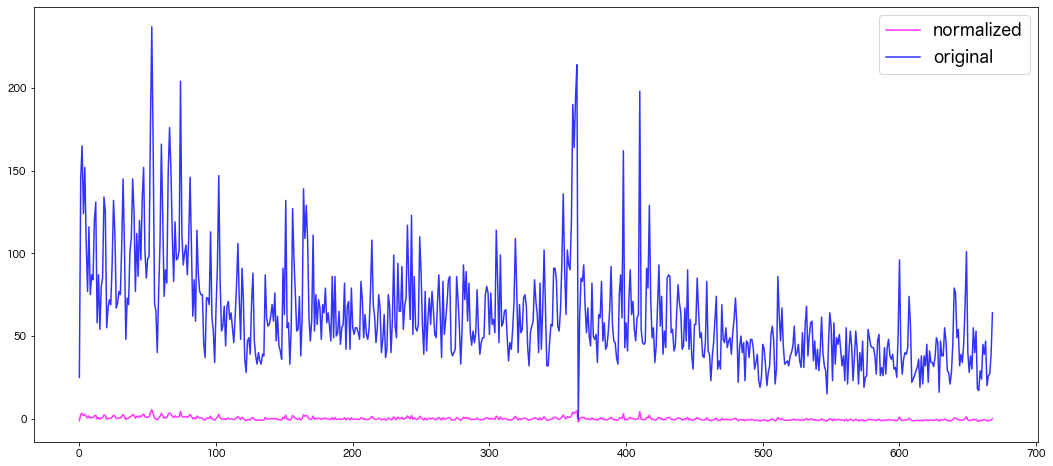

In [88]:
clusters_df_after_std = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_train)
plt.figure(figsize=(18, 8))
plt.plot(clusters_df_after_std[10] ,c='magenta',alpha=0.8,label="normalized")
plt.plot(clusters_df_after.iloc[:,10].values,c='blue',alpha=0.8,label="original")
plt.legend(fontsize=17)

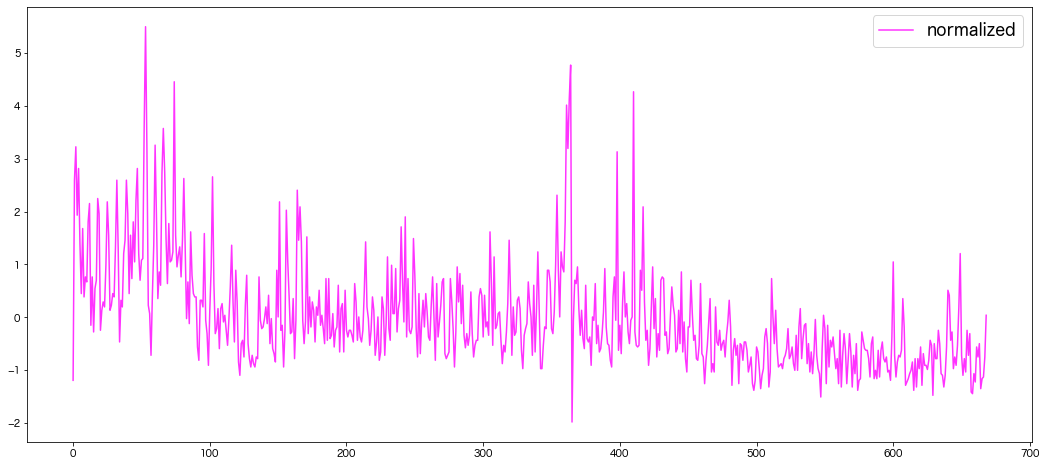

In [89]:
clusters_df_after_std = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_train)
plt.figure(figsize=(18, 8))
plt.plot(clusters_df_after_std[10] ,c='magenta',alpha=0.8,label="normalized")
# plt.plot(clusters_df_after.iloc[:,0].values,c='blue',alpha=0.8,label="original")
plt.legend(fontsize=17)

In [216]:
distortions = []

#1~10クラスタまで計算
for i in range(2,10):
    print('*'*100)
    print("Start ",i)
    ks = KShape(n_clusters=i, n_init=10, verbose=True, random_state=77)
    #クラスタリングの計算を実行
    ks.fit(X_train)
    #ks.fitするとks.inertia_が得られる
    #inertia_でSSEを取得できる
    distortions.append(ks.inertia_)

plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

****************************************************************************************************
Start  2
Init 1
0.394 --> 0.370 --> 0.291 --> 0.257 --> 0.255 --> 0.256 --> 
Init 2
0.396 --> 0.288 --> 0.262 --> 0.262 --> 
Init 3
0.396 --> 0.288 --> 0.262 --> 0.262 --> 
Init 4
Resumed because of empty cluster
Init 4
0.388 --> 0.291 --> 0.258 --> 0.256 --> 0.257 --> 
Init 5
0.390 --> 0.289 --> 0.262 --> 0.262 --> 
Init 6
0.399 --> 0.400 --> 
Init 7
0.392 --> 0.365 --> 0.271 --> 0.254 --> 0.255 --> 
Init 8
0.398 --> 0.398 --> 0.398 --> 
Init 9
0.396 --> 0.288 --> 0.262 --> 0.262 --> 
****************************************************************************************************
Start  3
Init 1
0.383 --> 0.305 --> 0.257 --> 0.250 --> 0.251 --> 
Init 2
0.389 --> 0.279 --> 0.250 --> 0.250 --> 0.251 --> 
Init 3
Resumed because of empty cluster
Init 3
0.383 --> 0.303 --> 0.258 --> 0.255 --> 0.256 --> 
Init 4
0.388 --> 0.326 --> 0.262 --> 0.250 --> 0.251 --> 
Init 5
0.387 --> 0.386 -->

EmptyClusterError: Cluster assignments lead to at least one empty cluster

In [217]:
distortions

[0.2541214378747778,
 0.24992686685591675,
 0.24490731734975857,
 0.3609846393776357,
 0.3622440776466084]

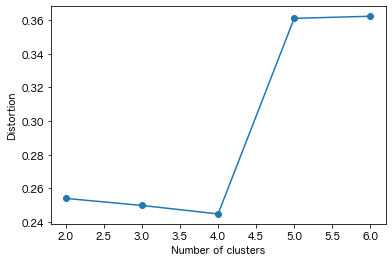

In [221]:
plt.plot(range(2,len(distortions)+2), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [219]:
print(ks.inertia_)

0.3573011760248352


In [92]:
ks = KShape(n_clusters=4, max_iter=50, n_init=10, verbose=True)
ks.fit(X_train)
print(ks.inertia_)
y_pred_shop = ks.fit_predict(X_train)
print(y_pred_shop)

Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
0.370 --> 0.254 --> 0.244 --> 0.244 --> 
Init 2
Resumed because of empty cluster
Init 2
0.374 --> 0.373 --> Resumed because of empty cluster
Init 2
Resumed because of empty cluster
Init 2
0.372 --> 0.370 --> 0.371 --> 
Init 3
Resumed because of empty cluster
Init 3
0.370 --> Resumed because of empty cluster
Init 3
0.385 --> Resumed because of empty cluster
0.24386597650879654
Init 1
0.373 --> 0.372 --> Resumed because of empty cluster
Init 1
0.372 --> Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
0.383 --> Resumed because of empty cluster
Init 1
0.378 --> 0.375 --> 0.373 --> 0.372 --> 0.371 --> 0.371 --> 0.369 --> 0.368 --> 0.367 --> 0.365 --> 0.363 --> 0.362 --> 0.361 --> 0.360 --> 0.358 --> 0.357 --> 0.355 --> 0.354 --> 0.353 --> 0.353 --> 0.351 --> 0.350 --> 0.348 --> 0.347 --> 0.346 --> 0.346 --> 
Init 2
0.379 --> Resumed b

In [93]:
y_pred_shop

array([3, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2])

In [94]:
shopID_sales_clusters_df = pd.DataFrame(clusters_df_after.T.index, columns=['店舗ID'])
shopID_sales_clusters_df['店舗別_売上個数_クラスタ'] = y_pred_shop
shopID_sales_clusters_df['店舗別_売上個数_クラスタ_cat'] = shopID_sales_clusters_df['店舗別_売上個数_クラスタ'].astype(str)
shopID_sales_clusters_df

,店舗ID,店舗別_売上個数_クラスタ,店舗別_売上個数_クラスタ_cat
0,0,3,3
1,1,3,3
2,10,2,2
3,13,2,2
4,14,2,2
5,15,2,2
6,2,0,0
7,5,2,2
8,6,2,2
9,7,2,2


In [95]:

dataset_addfeature_lag_trend_clusters = pd.merge(dataset_addfeature_lag_trend_clusters, shopID_sales_clusters_df, on=['店舗ID'], how='left')

In [96]:
dataset_addfeature_lag_trend_clusters

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,

### 商品ID の 日付ごと 売上個数別 クラスタリング

In [97]:
n_clusters_df = train_merged_data.groupby(['日付', '商品ID'])['売上個数'].sum().reset_index()
n_clusters_df = n_clusters_df.set_index('日付')
n_clusters_df

,商品ID,売上個数
日付,,
2018-01-01,1000001,3.0
2018-01-01,1000017,2.0
2018-01-01,1000018,1.0
2018-01-01,1000027,1.0
2018-01-01,1000028,2.0
...,...,...
2019-10-31,3400006,1.0
2019-10-31,3400009,1.0
2019-10-31,3400012,1.0


In [98]:
n_clusters_df['商品ID'].nunique()

9039

In [99]:
clusters_df_after = pd.DataFrame()
for ID in tqdm(n_clusters_df['商品ID'].unique()):
    clusters_df_cat = n_clusters_df[n_clusters_df['商品ID'] == ID]['売上個数']
    clusters_df_after = pd.concat([clusters_df_after, clusters_df_cat], axis=1)
    clusters_df_after = clusters_df_after.fillna(0)
clusters_df_after.columns = [ID for ID in n_clusters_df['商品ID'].unique()]
# clusters_df_after = clusters_df_after.reset_index()

  0%|          | 0/9039 [00:00<?, ?it/s]

In [100]:
X_train = to_time_series_dataset(clusters_df_after.T)
# X_train

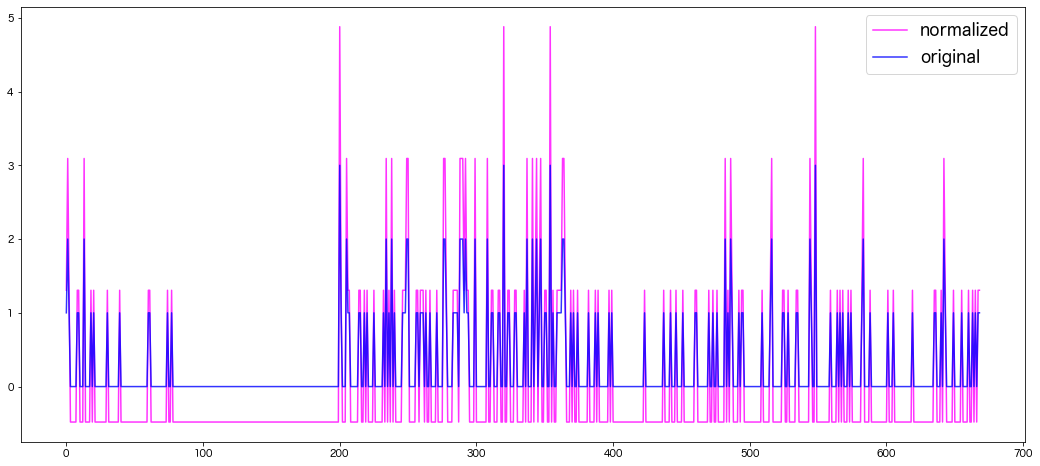

In [101]:
clusters_df_after_std = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_train)
plt.figure(figsize=(18, 8))
plt.plot(clusters_df_after_std[600] ,c='magenta',alpha=0.8,label="normalized")
plt.plot(clusters_df_after.iloc[:,600].values,c='blue',alpha=0.8,label="original")
plt.legend(fontsize=17)

In [102]:
data_train = np.array(clusters_df_after).T
X_train = to_time_series_dataset(data_train)

print("時系列データの総数 : ",len(data_train))
print("クラスの数 : ", len(np.unique(data_train[:,0])))
print("時系列の長さ : ",len(data_train[0,1:]))

時系列データの総数 :  9039
クラスの数 :  13
時系列の長さ :  668


In [236]:
distortions = []

#1~10クラスタまで計算
for i in range(2,50):
    print("Start ",i)
    ks = KShape(n_clusters=i, n_init=10, verbose=True, random_state=77)
    #クラスタリングの計算を実行
    ks.fit(X_train)
    #ks.fitするとks.inertia_が得られる
    #inertia_でSSEを取得できる
    distortions.append(ks.inertia_)

Start  2
Init 1
0.319 --> 0.317 --> 0.317 --> 0.316 --> 0.316 --> 0.316 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 
Init 2
0.329 --> 0.329 --> 0.326 --> 0.322 --> 0.320 --> 0.319 --> 0.319 --> 0.319 --> 0.319 --> 
Init 3
0.307 --> 0.310 --> 
Init 4
0.327 --> 0.320 --> 0.317 --> 0.316 --> 0.314 --> 0.313 --> 0.312 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.310 --> 0.310 --> 0.310 --> 0.310 --> 0.310 --> 0.310 --> 
Init 5
0.338 --> 0.326 --> 0.323 --> 0.321 --> 0.320 --> 0.317 --> 0.314 --> 0.313 --> 0.

EmptyClusterError: Cluster assignments lead to at least one empty cluster

In [237]:
distortions

[0.3066093253766616,
 0.2989723196063154,
 0.29381983384034865,
 0.28943871631556806,
 0.2845686041920366,
 0.2750676510688137,
 0.2731866489990337,
 0.27218607059664246,
 0.27029016076819046,
 0.2629326771843145,
 0.26921226942433396,
 0.26449194755775474,
 0.2628462251452486,
 0.26562108581601895,
 0.2631994418182567,
 0.2597372651659168,
 0.2625123879064878,
 0.2612003453365889,
 0.2613084953294466,
 0.2579710740471942,
 0.25654404014392773,
 0.2574824254797998,
 0.25787699192954977,
 0.25151417375778745,
 0.25638686072543887,
 0.2567369909352186,
 0.2557335855110107,
 0.25168691501501705,
 0.2475778053034905,
 0.25429153806056415]

ValueError: x and y must have same first dimension, but have shapes (48,) and (30,)

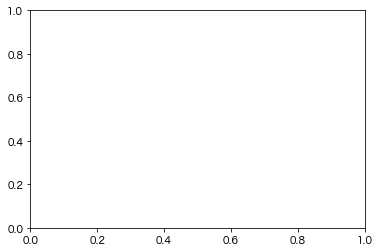

In [238]:
plt.plot(range(2,50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

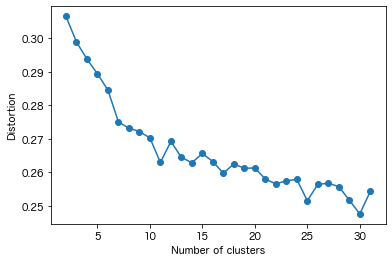

In [239]:
plt.plot(range(2,len(distortions)+2), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [103]:
#クラスタ数 11
ks = KShape(n_clusters=11, max_iter=10, n_init=10, verbose=True)
ks.fit(X_train)
print(ks.inertia_)
y_pred_item = ks.fit_predict(X_train)
print(y_pred_item)

Init 1
0.282 --> 0.279 --> 0.277 --> 0.279 --> 
Init 2
0.300 --> 0.279 --> 0.274 --> 0.275 --> 
Init 3
0.286 --> 0.269 --> 0.272 --> 
Init 4
0.295 --> 0.292 --> 0.289 --> 0.289 --> 0.288 --> 0.286 --> 0.289 --> 
Init 5
Resumed because of empty cluster
Init 5
0.277 --> 0.277 --> 
Init 6
Resumed because of empty cluster
Init 6
0.293 --> 0.293 --> 0.289 --> 0.283 --> 0.282 --> 0.280 --> 0.275 --> 0.274 --> 0.275 --> 
Init 7
0.298 --> 0.293 --> 0.291 --> 0.286 --> 0.286 --> 0.287 --> 
Init 8
0.295 --> 0.277 --> 0.278 --> 
0.26928752881092693
Init 1
0.295 --> 0.286 --> 0.285 --> 0.272 --> 0.271 --> 0.272 --> 
Init 2
0.295 --> 0.288 --> 0.288 --> 
Init 3
0.294 --> 0.286 --> 0.287 --> 
Init 4
0.285 --> 0.280 --> 0.279 --> 0.281 --> 
Init 5
0.284 --> 0.282 --> 0.283 --> 
Init 6
0.288 --> 0.285 --> 0.284 --> 0.281 --> 0.279 --> 0.279 --> 
Init 7
0.290 --> 0.285 --> 0.285 --> 
Init 8
0.288 --> 0.284 --> 0.285 --> 
Init 9
0.296 --> 0.282 --> 0.279 --> 0.281 --> 
Init 10
0.301 --> 0.291 --> 0.288 

In [104]:
itemID_sales_clusters_df = pd.DataFrame(clusters_df_after.T.index, columns=['商品ID'])
itemID_sales_clusters_df['商品別_売上個数_クラスタ'] = y_pred_item
itemID_sales_clusters_df['商品別_売上個数_クラスタ_cat'] = itemID_sales_clusters_df['商品別_売上個数_クラスタ'].astype(str)
itemID_sales_clusters_df

,商品ID,商品別_売上個数_クラスタ,商品別_売上個数_クラスタ_cat
0,1000001,0,0
1,1000017,7,7
2,1000018,10,10
3,1000027,8,8
4,1000028,1,1
...,...,...,...
9034,1201333,8,8
9035,1300369,8,8
9036,1700230,8,8
9037,2100176,8,8


In [105]:
dataset_addfeature_lag_trend_clusters = pd.merge(dataset_addfeature_lag_trend_clusters, itemID_sales_clusters_df, on=['商品ID'], how='left')

In [106]:
dataset_addfeature_lag_trend_clusters

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,

In [107]:
dataset_addfeature_lag_trend_clusters.to_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')

In [108]:
# dataset_addfeature_lag_trend_clusters = pd.read_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')

## 店舗IDごと 商品売上比率 ポートフォリオ

In [109]:
dataset_addfeature_lag_trend_clusters_portfolio = dataset_addfeature_lag_trend_clusters.copy()

In [110]:
df = pd.DataFrame()

for ID in tqdm(dataset_addfeature_lag_trend_clusters_portfolio['店舗ID'].unique()):
    group = train_merged_data.groupby(['店舗ID', '商品カテゴリ名'])['売上個数'].sum().reset_index()
    _df = group[group['店舗ID'] == ID]
    _df['売上個数_比率'] = _df['売上個数'] / _df.T.sum(axis=1)['売上個数']
    _df = _df.drop(columns='売上個数')
    df = pd.concat([df, _df])
dataset_addfeature_lag_trend_clusters_portfolio = pd.merge(dataset_addfeature_lag_trend_clusters_portfolio, df, on=['店舗ID','商品カテゴリ名'], how='left')

  0%|          | 0/18 [00:00<?, ?it/s]

In [111]:
dataset_addfeature_lag_trend_clusters_portfolio

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,

In [112]:
group = train_merged_data.groupby('店舗ID')['売上個数'].sum().reset_index().sort_values('売上個数').reset_index(drop=True)
group['店舗売上個数_順位'] = group['売上個数'].rank(ascending=False)
group.drop('売上個数', axis=1,inplace=True)
dataset_addfeature_lag_trend_clusters_portfolio = pd.merge(dataset_addfeature_lag_trend_clusters_portfolio, group, on=['店舗ID'], how='left')

## 欠損値を0で埋める

In [113]:
# dataset3 = dataset3.fillna(0)
# dataset3.head()

# 特徴量を追加したデータフレームを保存

In [114]:
dataset_addfeature_lag_trend_clusters_portfolio[dataset_addfeature_lag_trend_clusters_portfolio.月ブロック >= 12]

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,

In [115]:
dataset_addfeature_lag_trend_clusters_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648548 entries, 0 to 1648547
Columns: 490 entries, 月ブロック to 店舗売上個数_順位
dtypes: float16(449), float64(7), int64(20), int8(2), object(12)
memory usage: 1.9+ GB


In [116]:
dataset_addfeature_lag_trend_clusters_portfolio.to_pickle('./inputs/dataset_addfeature_lag_trend_clusters_portfolio.pickle')

In [ ]:
# dataset_addfeature_lag_trend_clusters = pd.read_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')

# 説明変数の前処理

In [337]:
dataset_addfeature_lag_trend_clusters_portfolio.月ブロック.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [339]:
dataset_addfeature_lag_trend_clusters_portfolio_12 = dataset_addfeature_lag_trend_clusters_portfolio[(dataset_addfeature_lag_trend_clusters_portfolio.月ブロック >= 12) & (dataset_addfeature_lag_trend_clusters_portfolio.月ブロック <= 20)]

In [340]:
#数値の説明変数のリストを作成
num_feats = dataset_addfeature_lag_trend_clusters_portfolio_12.dtypes[dataset_addfeature_lag_trend_clusters_portfolio_12.dtypes != "object" ].index
print(num_feats)

Index(['月ブロック', '商品価格sum', '商品価格mean', '売上個数', '売上個数mean', '売上個数count',
       '売上個数_2month', 'year', 'month', 'month_cos',
       ...
       'delta_商品カテゴリ_type3別_売上金額_lag_6', 'delta_商品カテゴリ_type3別_売上金額_lag_12',
       'days', 'item_shop_last_sale', 'item_shop_first_sale',
       'item_first_sale', '店舗別_売上個数_クラスタ', '商品別_売上個数_クラスタ', '売上個数_比率',
       '店舗売上個数_順位'],
      dtype='object', length=478)


<AxesSubplot:>

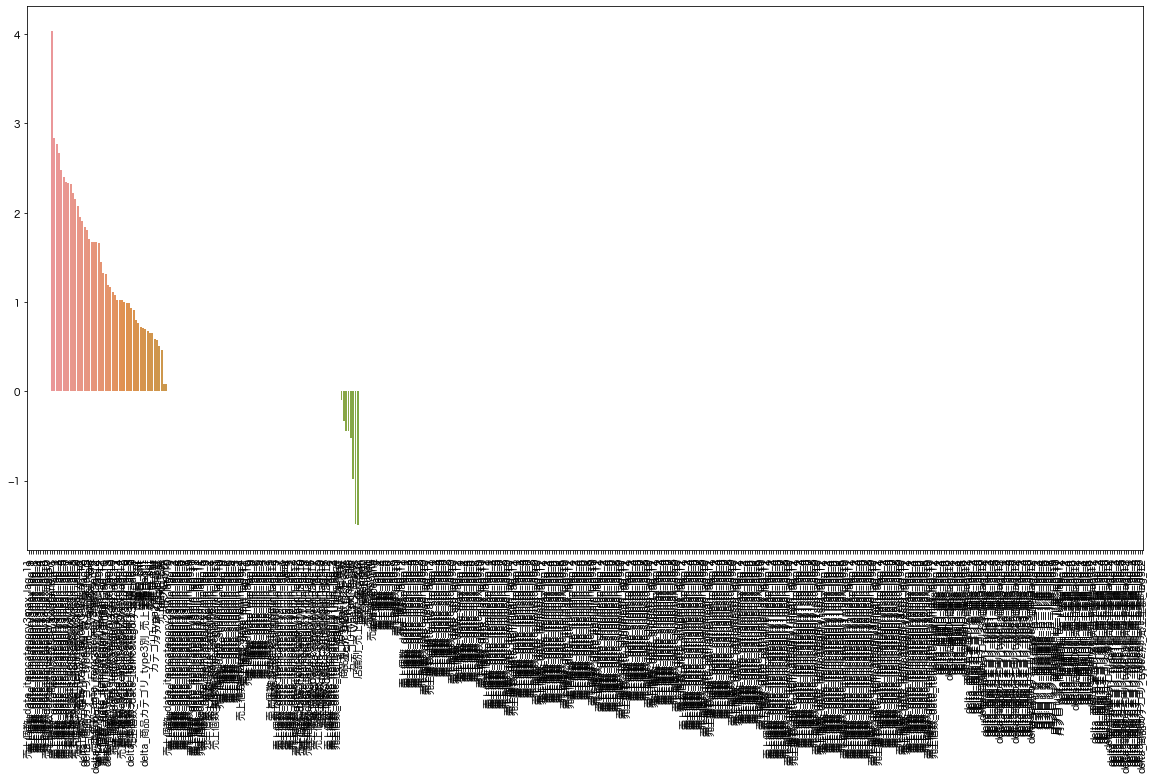

In [341]:
#各説明変数の歪度を計算
skewed_feats = dataset_addfeature_lag_trend_clusters_portfolio_12[num_feats].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)

In [343]:
#歪度の絶対値が0.5より大きい変数だけに絞る
skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5].index

#各変数の最小値を表示
for i in skewed_feats_over:
    print(min(dataset_addfeature_lag_trend[i]))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0
nan
nan
nan
-1
0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
4
4
4
4
nan
4
4
4
73
16


KeyError: '売上個数_比率'

In [344]:
skewed_feats_over

Index(['売上個数_date_itemcategory3max_lag_11', '売上個数_date_itemcategory3max_lag_9',
       '売上個数_date_itemcategory3max_lag_1', '売上個数_date_itemcategory3max_lag_8',
       '売上個数_date_itemcategory3max_lag_3', '売上個数_date_itemcategory3max_lag_4',
       '売上個数_date_itemcategory3max_lag_5', '売上個数_date_itemcategory3max_lag_6',
       '売上個数_date_itemcategory3max_lag_10', '売上個数_date_itemcategory3max_lag_7',
       '商品カテゴリ名_contains_PC', '売上個数_date_itemcategory3mean_lag_1',
       '売上個数_date_itemcategory3mean_lag_2',
       '売上個数_date_itemcategory3mean_lag_3',
       '売上個数_date_itemcategory3mean_lag_4',
       '売上個数_date_itemcategory3mean_lag_5',
       '売上個数_date_itemcategory3mean_lag_6',
       '売上個数_date_itemcategory3mean_lag_7', '売上個数_date_itemcategory3std_lag_1',
       '売上個数_date_itemcategory3mean_lag_8', '売上個数_date_itemcategory3std_lag_2',
       '売上個数_date_itemcategory3mean_lag_9', '商品カテゴリ名_contains_ゲーム',
       '売上個数_date_itemcategory3std_lag_12', 'delta_商品カテゴリ_type3別_売上金額_lag_6',
       'de

## 対数変換した説明変数を追加

['月ブロック', '売上個数_lag_1', '売上個数_lag_2', '売上個数_lag_3', '売上個数_lag_6', '売上個数_lag_12', 'date_avg_売上個数_lag_1', 'date_avg_売上個数_lag_2', 'date_avg_売上個数_lag_3', 'date_avg_売上個数_lag_6', 'date_avg_売上個数_lag_12', 'date_item_avg_売上個数_lag_1', 'date_item_avg_売上個数_lag_2', 'date_item_avg_売上個数_lag_3', 'date_item_avg_売上個数_lag_6', 'date_item_avg_売上個数_lag_12', 'date_shop_avg_売上個数_lag_1', 'date_shop_avg_売上個数_lag_2', 'date_shop_avg_売上個数_lag_3', 'date_shop_avg_売上個数_lag_6', 'date_shop_avg_売上個数_lag_12', 'date_catname_avg_売上個数_lag_1', 'date_cattype1_avg_売上個数_lag_1', 'date_cattype1_avg_売上個数_lag_2', 'date_cattype1_avg_売上個数_lag_3', 'date_cattype1_avg_売上個数_lag_6', 'date_cattype1_avg_売上個数_lag_12', 'date_cattype2_avg_売上個数_lag_1', 'date_cattype2_avg_売上個数_lag_2', 'date_cattype2_avg_売上個数_lag_3', 'date_cattype2_avg_売上個数_lag_6', 'date_cattype2_avg_売上個数_lag_12', 'date_cattype3_avg_売上個数_lag_1', 'date_cattype3_avg_売上個数_lag_2', 'date_cattype3_avg_売上個数_lag_3', 'date_cattype3_avg_売上個数_lag_6', 'date_cattype3_avg_売上個数_lag_12', 'year',

ValueError: min() arg is an empty sequence

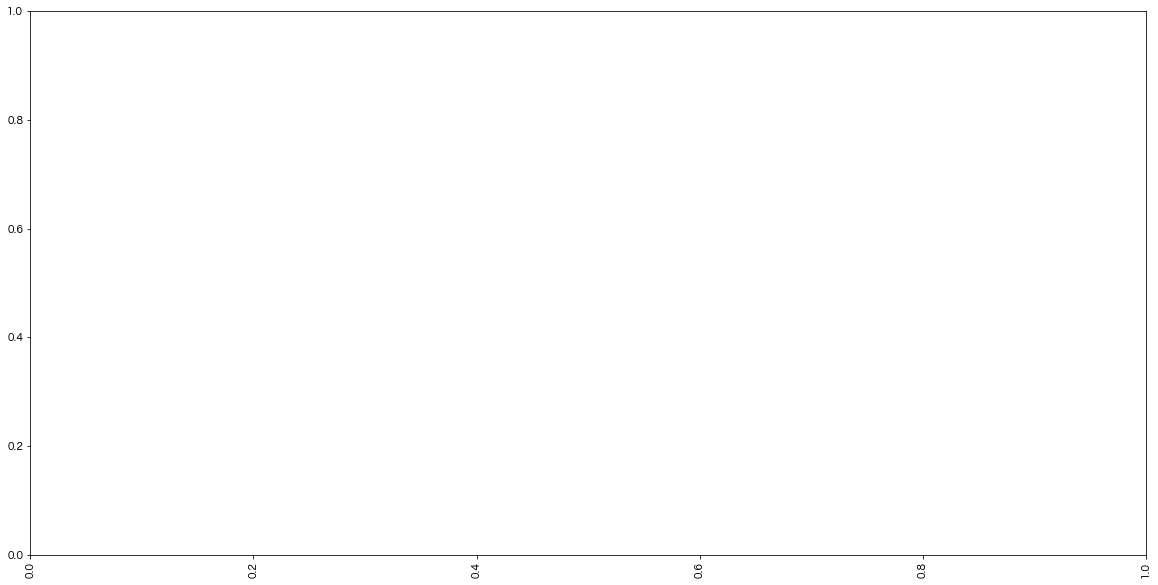

In [35]:
X_data_log, num_col_feat_list, pt = logarithmic_transformation(X_data)

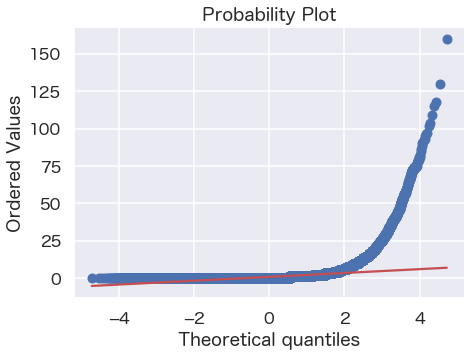

In [88]:
import scipy.stats as stats
 
sns.set(font="Hiragino Maru Gothic Pro",context="talk")
fig = plt.subplots(figsize=(7,5))
 
stats.probplot(y_train, dist="norm", plot=plt)
plt.show()

In [85]:
y_train_log = np.log1p(y_train)

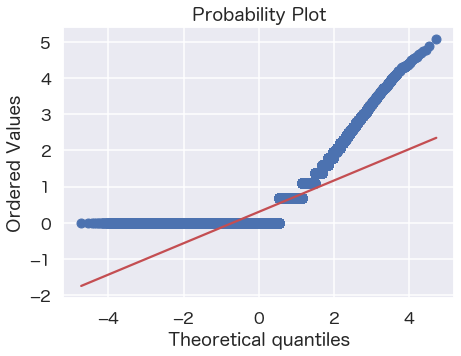

In [87]:
import scipy.stats as stats
 
sns.set(font="Hiragino Maru Gothic Pro",context="talk")
fig = plt.subplots(figsize=(7,5))
 
stats.probplot(y_train_log, dist="norm", plot=plt)
plt.show()

train_y
歪度: nan
尖度: nan
np.exp(train_y_log)
歪度: nan
尖度: nan


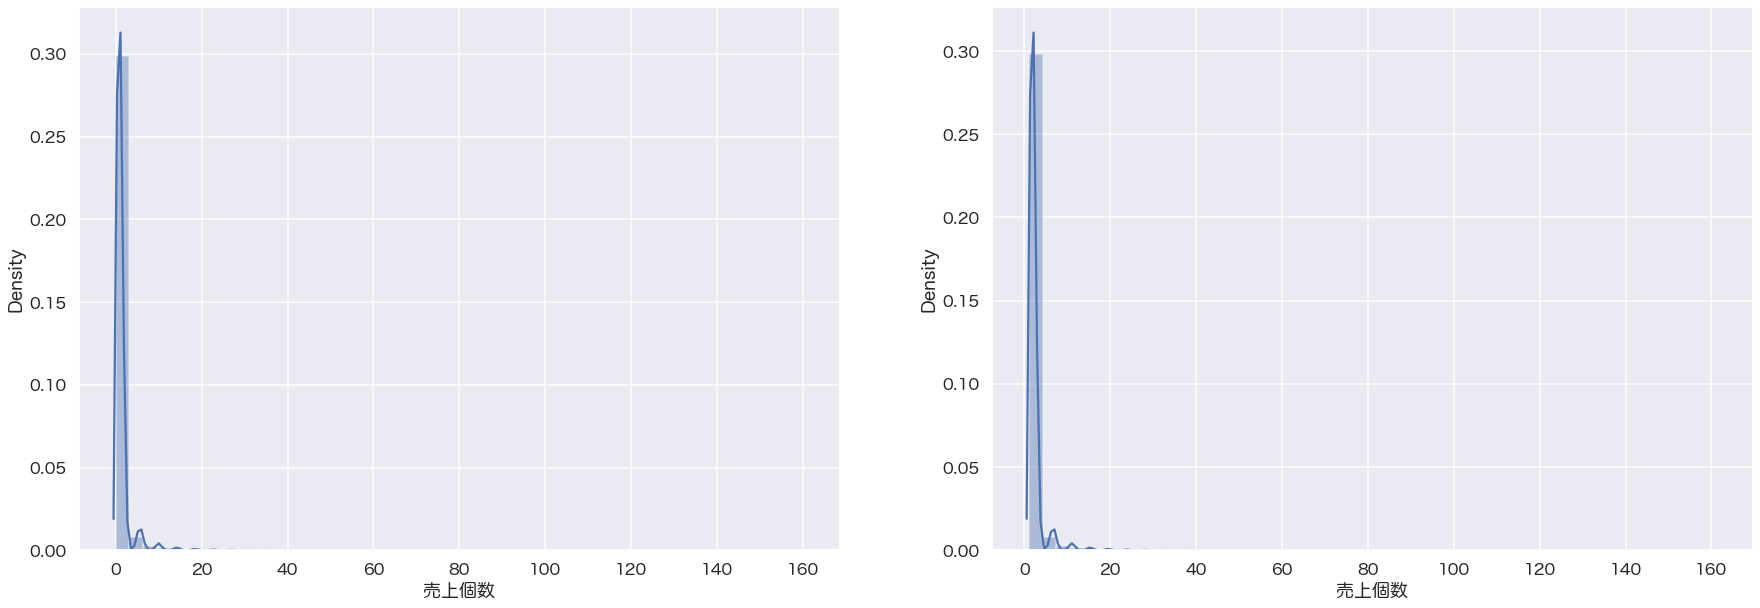

In [94]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 10])

sns.distplot(y_train, ax=ax1)
#歪度と尖度を計算
print('train_y')
print("歪度: %f" % y_train.skew())
print("尖度: %f" % y_train.kurt())

print('=============')

sns.distplot(np.exp(y_train_log), ax=ax2)
print('np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % np.exp(y_train_log).skew())
print("尖度: %f" % np.exp(y_train_log).kurt())